<h1><center>MARÍA VICTORIA SANTANA RODRÍGUEZ </center></h1>
<font color="darkblue">
<h3> <center>TFM</center> </h3>
<h3> <center>Julio-Agosto 2024</center> </h3>

<font color="darkblue"><h2> Previsión_CORREOS</h2> 

**Objetivo**: Hacer previsiones de los datos que se tiene de correos.

In [1]:
# Se importan los paquetes y librerías necesarias
import pandas as pd
import os
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from pmdarima import auto_arima
import joblib
import re 
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

### A. Carga del fichero

Se carga el fichero que previamente ha sido limpiado y procesado

In [2]:
# Ruta en la que se encuentra el fichero
Ruta_Correos_Unico = './Ficheros_unico/C_Unico.csv'

# Se carga el DataFrame desde el archivo CSV
Correo_merge_pivotar = pd.read_csv(Ruta_Correos_Unico, parse_dates=['Fecha'])

# Se comprueba que se carga correctamente
print(Correo_merge_pivotar.head())

                Aeropuerto_Base             Tipo      Fecha    Valor
0                      A CORUÑA  C_Total_Llegada 2004-01-01        0
1  ADOLFO SUÁREZ MADRID-BARAJAS  C_Total_Llegada 2004-01-01  1274688
2                      ALBACETE  C_Total_Llegada 2004-01-01        0
3   ALICANTE-ELCHE MIGUEL HDEZ.  C_Total_Llegada 2004-01-01      517
4                       ALMERÍA  C_Total_Llegada 2004-01-01        0


In [3]:
# Se modifica el nombre del fichero
Correo_Unico = Correo_merge_pivotar

# Se comprueba que tipo de dato hay en cada columna y que es correcto
print(Correo_Unico.dtypes)

# Asegurarse de que la fecha sea el índice para el análisis de series temporales
Correo_Unico.set_index('Fecha', inplace=True)

# Se comprueba que se carga correctamente
print(Correo_Unico.head())

Aeropuerto_Base            object
Tipo                       object
Fecha              datetime64[ns]
Valor                       int64
dtype: object
                         Aeropuerto_Base             Tipo    Valor
Fecha                                                             
2004-01-01                      A CORUÑA  C_Total_Llegada        0
2004-01-01  ADOLFO SUÁREZ MADRID-BARAJAS  C_Total_Llegada  1274688
2004-01-01                      ALBACETE  C_Total_Llegada        0
2004-01-01   ALICANTE-ELCHE MIGUEL HDEZ.  C_Total_Llegada      517
2004-01-01                       ALMERÍA  C_Total_Llegada        0


### B. Predicciones

En este apartado se trata de hacer las predicciones de los datos estudiados, para ello se van a probar distintos modelos hasta encontrar el que mejores resultados arroje. No se van a usar tantos modelos como en para los ficheros de operaciones.

In [4]:
import warnings
warnings.filterwarnings("ignore")

**1. Modelo ARIMA**

Se prueba un modelo Arima, con unos parámetros aleatorios, muy básicos de (1,1,1) para ver que resultados se obtienen, y partir de esta base, al igual que se ha hecho con los otros ficheros. 

In [5]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Correo = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Correo_Unico['Aeropuerto_Base'].unique()
Tipos_Correos = Correo_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Correo in Tipos_Correos:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Correo = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Correo_Unico['Tipo'] == Correo)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Correo = Datos_Reales_Correo.sort_index()
        Datos_Reales_Correo = Datos_Reales_Correo.asfreq('MS')
        
        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima = ARIMA(Datos_Reales_Correo['Valor'], order=(1, 1, 1))
            model_fit_arima = model_arima.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales = model_fit_arima.predict(start=Datos_Reales_Correo.index[0], end=Datos_Reales_Correo.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras = model_fit_arima.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Correo[(Aeropuerto, Correo)] = (Predicciones_Originales, Predicciones_Futuras, Datos_Reales_Correo.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Correo}: {e}")

**1-a. Almacenar las predicciones**

In [6]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Correo = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales, Predicciones_Futuras, Fechas_Reales) in Dicc_Predicciones_Correo.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Predicciones_Originales = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras), freq='MS')
    Predicciones_Futuras = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Correo = pd.concat([Predicciones_Correo, Predicciones_Originales, Predicciones_Futuras], ignore_index=True)

In [7]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_C = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales, Predicciones_Futuras, Fechas_Reales) in Dicc_Predicciones_Correo.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Valor Real': Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Correo_Unico['Tipo'] == Correo)]['Valor'],
        'Prediccion': Predicciones_Originales
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras), freq='MS')
    Temp_Predicciones_Futuras = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras),
        'Prediccion': Predicciones_Futuras
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_C = pd.concat([Comparacion_Total_Todos_Aeropuertos_C, Tem_Predicciones_Historicas, Temp_Predicciones_Futuras], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01          0    0.004246
50549  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01          0    0.004152
50550  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01          0    0.004059
50551  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01          0    0.003968
50552  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01          0    0.003880
50553  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01          0    0.003793
50554  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01          0    0.003709
50555  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01          0    0.003626
50556  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01       None    0.003545
50557  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01       None    0.004963
50558  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01       None    0.005530
50559  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01       None    0.005757

In [8]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_C['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_C['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_C['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_C['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01       0,00       0,00
50549  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01       0,00       0,00
50550  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01       0,00       0,00
50551  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01       0,00       0,00
50552  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01       0,00       0,00
50553  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01       0,00       0,00
50554  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01       0,00       0,00
50555  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01       0,00       0,00
50556  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01                  0,00
50557  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01                  0,00
50558  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01                  0,01
50559  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01                  0,01
50560  MURCI

**1-b. Visualizar predicciones**

**Pasajeros de llegada**, se visualizan las predicciones para un aeropuerto en particular que se guardan en un mismo dataframe, los datos reales con las predicciones de los rangos de fecha de los datos que se tienen junto con un periodo de 12 meses adicionales

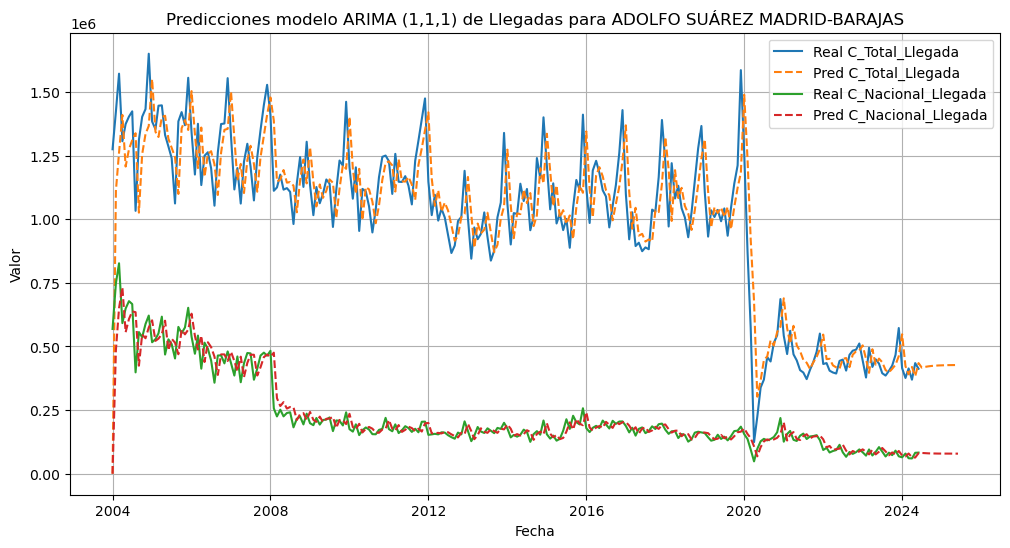

In [9]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de mercancias disponibles para el aeropuerto seleccionado
Tipos_Correos = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Correos if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Correo_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de mercancia
    Datos_Reales_Correos = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correo_Prediccion)]
    
    # Se filtran las predicciones para el tipo de mercancia
    Datos_Predicciones_Correos = Predicciones_Correo[(Predicciones_Correo['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correo['Tipo'] == Tipo_Correo_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correos.index, Datos_Reales_Correos['Valor'], label=f'Real {Tipo_Correo_Prediccion}')
    plt.plot(Datos_Predicciones_Correos['Fecha'], Datos_Predicciones_Correos['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correo_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo ARIMA (1,1,1) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**Pasajeros de salida**, se visualizan las predicciones, para un aeropuerto en particular que se guardan en un mismo dataframe, los datos reales con las predicciones de los rangos de fecha de los datos que se tienen junto con un periodo de 12 meses adicionales.

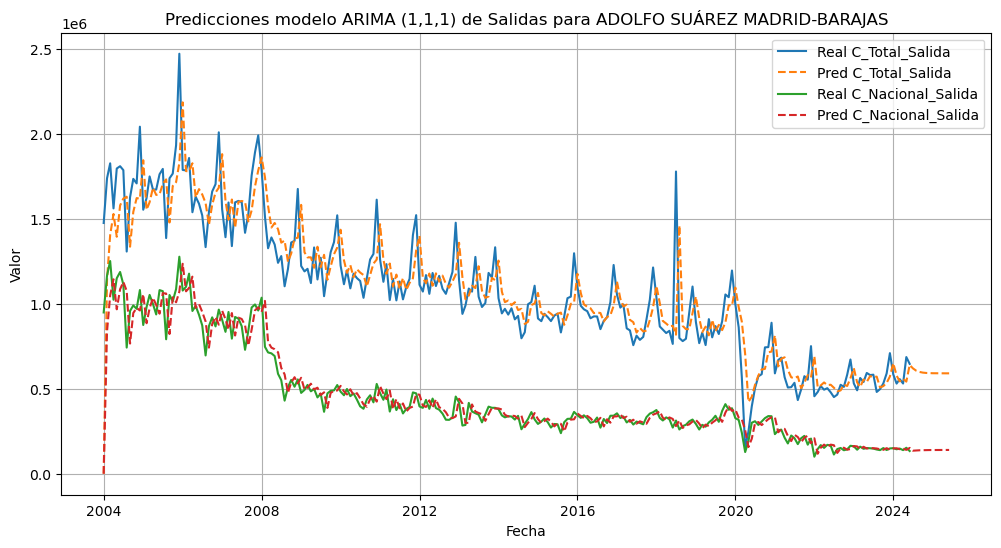

In [11]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de mercancias disponibles para el aeropuerto seleccionado
Tipos_Correos = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Correos if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Correo_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de mercancia
    Datos_Reales_Correos = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correo_Prediccion)]
    
    # Se filtran las predicciones para el tipo de mercancia
    Datos_Predicciones_Correos = Predicciones_Correo[(Predicciones_Correo['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correo['Tipo'] == Tipo_Correo_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correos.index, Datos_Reales_Correos['Valor'], label=f'Real {Tipo_Correo_Prediccion}')
    plt.plot(Datos_Predicciones_Correos['Fecha'], Datos_Predicciones_Correos['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correo_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo ARIMA (1,1,1) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**1-c. Métricas de Error**

In [13]:
# Función para calcular SMAPE
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Se añade la métrica SMAPE
Metricas_Error_Correos = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Correo), (Predicciones_Historicas, _, Fechas_Reales) in Dicc_Predicciones_Correo.items():
    # Se obtienen los valores reales
    Valores_Reales_Correos = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Correo_Unico['Tipo'] == Correo)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Correos) == len(Predicciones_Historicas):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Correos, Predicciones_Historicas)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Correos, Predicciones_Historicas))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Correos - Predicciones_Historicas) / np.where(Valores_Reales_Correos == 0, 1, Valores_Reales_Correos))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Correos, Predicciones_Historicas)
        
        Temp_Metricas_Error = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Correo],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Correos = pd.concat([Metricas_Error_Correos, Temp_Metricas_Error], ignore_index=True)

    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Correo}")

# Se muestran las métricas
print(Metricas_Error_Correos)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     C_Total_Llegada      39.498747   
1                        A CORUÑA  C_Nacional_Llegada      33.708065   
2                        A CORUÑA      C_Total_Salida     170.463757   
3                        A CORUÑA   C_Nacional_Salida     170.389856   
4    ADOLFO SUÁREZ MADRID-BARAJAS     C_Total_Llegada  108674.907737   
..                            ...                 ...            ...   
191                     SON BONET   C_Nacional_Salida       0.021550   
192              MURCIA COMBINADO     C_Total_Llegada       1.313614   
193              MURCIA COMBINADO  C_Nacional_Llegada       0.000000   
194              MURCIA COMBINADO      C_Total_Salida       3.189575   
195              MURCIA COMBINADO   C_Nacional_Salida       0.282819   

              RMSE         MAPE       SMAPE  
0       159.744806  1049.822032  187.857479  
1       158.732034   822.369812  186.676774

Se calculan los datos promedios de los errores para así, tener una visión de conjunto

In [14]:
# Se calculan las métricas medias para este modelo 
MAE_promedio = Metricas_Error_Correos['MAE'].mean()
RMSE_promedio = Metricas_Error_Correos['RMSE'].mean()
MAPE_promedio= Metricas_Error_Correos['MAPE'].mean()
SMAPE_promedio = Metricas_Error_Correos['SMAPE'].mean()

# Se muestran los resultados ARIMA (1,1,1)
print(f"MAE Promedio ARIMA (1,1,1): {MAE_promedio}")
print(f"RMSE Promedio ARIMA (1,1,1): {RMSE_promedio}")
print(f"MAPE Promedio ARIMA (1,1,1): {MAPE_promedio}%")
print(f"SMAPE Promedio ARIMA (1,1,1): {SMAPE_promedio}%")

MAE Promedio ARIMA (1,1,1): 3131.3508177546555
RMSE Promedio ARIMA (1,1,1): 5385.876478790169
MAPE Promedio ARIMA (1,1,1): 2608.181466029708%
SMAPE Promedio ARIMA (1,1,1): 86.72088658911555%


Como se pueden ver en los valores promedio: 

- MAE Promedio ARIMA (1,1,1): 3131.3508177546555
- RMSE Promedio ARIMA (1,1,1): 5385.876478790169
- MAPE Promedio ARIMA (1,1,1): 2608.181466029708%
- SMAPE Promedio ARIMA (1,1,1): 86.72088658911555%

Los valores son muy alto para MAE y RSME, lo que indica que las predicciones y la precisión del modelo podría ser mejor, como el RMSE es mayor que el MAE indica que hay grandes errores de predicción, se siguen buscando otros modelos.

**2. Modelo Grid Search - ARIMA - 1 intento**

El segundo modelo es usar un Grid Search, para optimizar los hiperparámetros del modelo anterior, en teoría deberían de mejorar los resultados, ya que se están buscando los mejores para este conjunto de datos, y que así ofrezca un mejor rendimiento del mismo.

In [15]:
# Se definen los parámetros p, d, q
p = d = q = range(0, 4)  # Esto probará valores de 0 a 3 para p, d, q
pdq = list(itertools.product(p, d, q))

# Se almcenan los mejores resultados
best_aic = float('inf')
best_params = None

# Se itera sobre cada combinación de parámetros
for params in pdq:
    try:
        # Se entrena el modelo ARIMA con los parámetros actuales
        model_arima = ARIMA(Datos_Reales_Correos['Valor'], order=params)
        model_fit_arima = model_arima.fit()
        
        # Se calcular el AIC
        aic = model_fit_arima.aic
        
        # Si el AIC actual es mejor que el anterior, actualizar los mejores parámetros
        if aic < best_aic:
            best_aic = aic
            best_params = params
            
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

print(f'Mejor conjunto de parámetros: {best_params} con AIC: {best_aic}')

Mejor conjunto de parámetros: (3, 0, 0) con AIC: 6185.656098282943


El mejor conjunto de parámetros con Grind Search que se obtiene para los datos de operaciones es el (3, 0, 0)

- p (componente autorregresivo)=3
- d (componente integrado) =0
- q (media móvil) =0

**2-a. Se reentrena el modelo con los parámetros obtenidos, Modelo Grid Search - ARIMA - 1 intento**

In [16]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Correo_GS = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Correo_Unico['Aeropuerto_Base'].unique()
Tipos_Correos = Correo_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Correo in Tipos_Correos:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Correos_GS = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Correo_Unico['Tipo'] == Correo)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Correos_GS = Datos_Reales_Correos_GS.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_GS = ARIMA(Datos_Reales_Correos_GS['Valor'], order=(3, 0, 0))
            model_fit_arima_GS = model_arima_GS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_GS = model_fit_arima_GS.predict(start=Datos_Reales_Correos_GS.index[0], end=Datos_Reales_Correos_GS.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_GS = model_fit_arima_GS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Correo_GS[(Aeropuerto, Correo)] = (Predicciones_Originales_GS, Predicciones_Futuras_GS, Datos_Reales_Correos_GS.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Correo}: {e}")

**2-b. Dataframe en el que se guardan las predicciones y los datos reales**

In [17]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_GS_C = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_GS, Predicciones_Futuras_GS, Fechas_Reales) in Dicc_Predicciones_Correo_GS.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Valor Real': Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Correo_Unico['Tipo'] == Correo)]['Valor'],
        'Prediccion': Predicciones_Originales_GS
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS), freq='MS')
    Temp_Predicciones_Futuras_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_GS),
        'Prediccion': Predicciones_Futuras_GS
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_GS_C = pd.concat([Comparacion_Total_Todos_Aeropuertos_GS_C, Tem_Predicciones_Historicas_GS, Temp_Predicciones_Futuras_GS], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_GS_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01          0    0.071805
50549  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01          0    0.071805
50550  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01          0    0.071805
50551  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01          0    0.071805
50552  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01          0    0.071805
50553  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01          0    0.071805
50554  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01          0    0.071805
50555  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01          0    0.071805
50556  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01       None    0.071805
50557  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01       None    0.105863
50558  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01       None    0.110680
50559  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01       None    0.115641

In [18]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_GS_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GS_C['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_GS_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS_C['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_GS_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GS_C['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_GS_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS_C['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_GS_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01       0,00       0,07
50549  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01       0,00       0,07
50550  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01       0,00       0,07
50551  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01       0,00       0,07
50552  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01       0,00       0,07
50553  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01       0,00       0,07
50554  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01       0,00       0,07
50555  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01       0,00       0,07
50556  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01                  0,07
50557  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01                  0,11
50558  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01                  0,11
50559  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01                  0,12
50560  MURCI

**2-c. Visualización de las predicciones** 

In [19]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Correos_GS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_GS, Predicciones_Futuras_GS, Fechas_Reales) in Dicc_Predicciones_Correo_GS.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_GS
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS), freq='MS')
    Temp_Predicciones_Futuras_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_GS
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Correos_GS = pd.concat([Predicciones_Correos_GS, Tem_Predicciones_Historicas_GS, Temp_Predicciones_Futuras_GS], ignore_index=True)

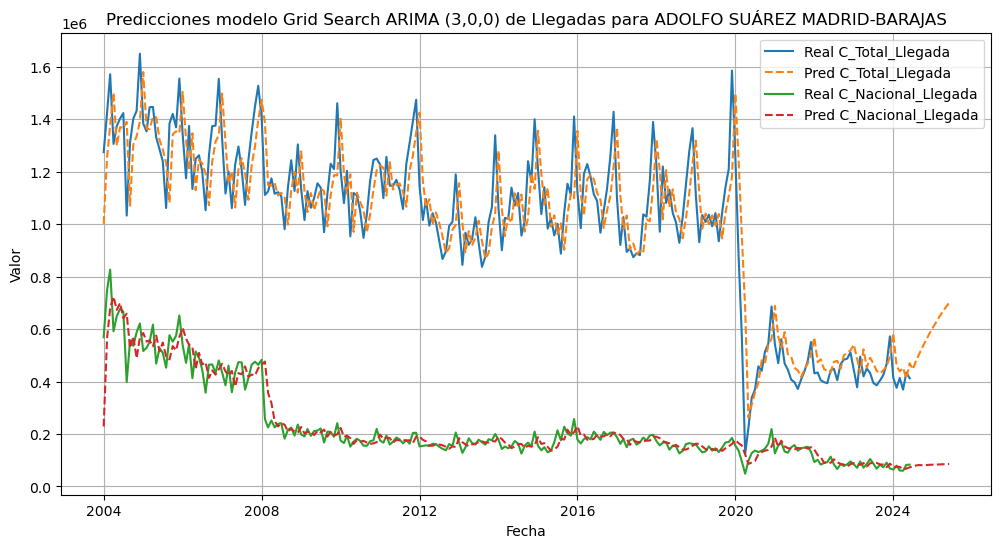

In [20]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correos = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Correos if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Correos_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correos_GS = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correos_GS = Predicciones_Correos_GS[(Predicciones_Correos_GS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correos_GS['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correos_GS.index, Datos_Reales_Correos_GS['Valor'], label=f'Real {Tipo_Correos_Prediccion}')
    plt.plot(Datos_Predicciones_Correos_GS['Fecha'], Datos_Predicciones_Correos_GS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correos_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (3,0,0) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

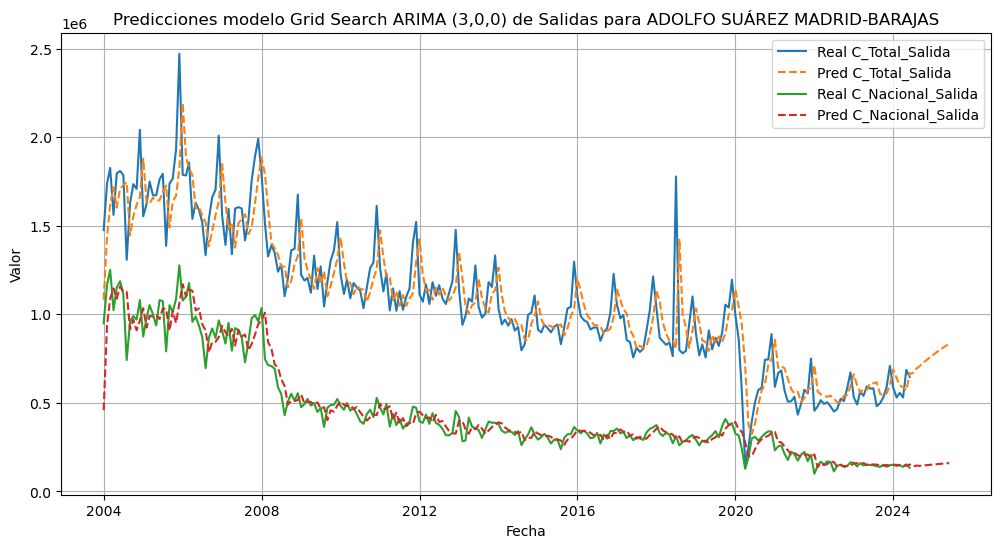

In [21]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correos = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Correos if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Correos_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correos_GS = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correos_GS = Predicciones_Correos_GS[(Predicciones_Correos_GS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correos_GS['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correos_GS.index, Datos_Reales_Correos_GS['Valor'], label=f'Real {Tipo_Correos_Prediccion}')
    plt.plot(Datos_Predicciones_Correos_GS['Fecha'], Datos_Predicciones_Correos_GS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correos_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (3,0,0) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**2-d. Métricas de error**

In [22]:
# Función para calcular SMAPE
def smape(y_true_GS, y_pred_GS):
    return 100 / len(y_true_GS) * np.sum(2 * np.abs(y_pred_GS - y_true_GS) / (np.abs(y_true_GS) + np.abs(y_pred_GS)))

# Se añade la métrica SMAPE
Metricas_Error_Correos_GS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Correo), (Predicciones_Originales_GS, _, Fechas_Reales) in Dicc_Predicciones_Correo_GS.items():
    # Se obtienen los valores reales
    Valores_Reales_Correos_GS = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Correo_Unico['Tipo'] == Correo)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Correos_GS) == len(Predicciones_Originales_GS):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Correos_GS, Predicciones_Originales_GS)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Correos_GS, Predicciones_Originales_GS))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Correos_GS - Predicciones_Originales_GS) / np.where(Valores_Reales_Correos_GS == 0, 1, Valores_Reales_Correos_GS))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Correos_GS, Predicciones_Originales_GS)
        
        Temp_Metricas_Error_GS = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Correo],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Correos_GS = pd.concat([Metricas_Error_Correos_GS, Temp_Metricas_Error_GS], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Correo}")

# Se muestran las métricas
print(Metricas_Error_Correos_GS)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     C_Total_Llegada      43.579536   
1                        A CORUÑA  C_Nacional_Llegada      43.235353   
2                        A CORUÑA      C_Total_Salida     198.652673   
3                        A CORUÑA   C_Nacional_Salida     198.648424   
4    ADOLFO SUÁREZ MADRID-BARAJAS     C_Total_Llegada  105141.154095   
..                            ...                 ...            ...   
191                     SON BONET   C_Nacional_Salida       0.032388   
192              MURCIA COMBINADO     C_Total_Llegada       1.276650   
193              MURCIA COMBINADO  C_Nacional_Llegada       0.000005   
194              MURCIA COMBINADO      C_Total_Salida       2.535394   
195              MURCIA COMBINADO   C_Nacional_Salida       0.181072   

              RMSE         MAPE       SMAPE  
0       156.636417  1902.130428  185.593395  
1       155.032924  1891.560466  185.656812

**2-e. Métricas de error promedias de todo el conjunto**

Se calculan los datos promedios de los errores para así, tener una visión de conjunto

In [23]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_GS = Metricas_Error_Correos_GS['MAE'].mean()
RMSE_promedio_GS = Metricas_Error_Correos_GS['RMSE'].mean()
MAPE_promedio_GS = Metricas_Error_Correos_GS['MAPE'].mean()
SMAPE_promedio_GS = Metricas_Error_Correos_GS['SMAPE'].mean()


# Se muestran los resultados GRID SEARCH ARIMA (3,0,0)
print(f"MAE Promedio GRID SEARCH ARIMA (3,0,0): {MAE_promedio_GS}")
print(f"RMSE Promedio GRID SEARCH ARIMA (3,0,0): {RMSE_promedio_GS}")
print(f"MAPE Promedio GRID SEARCH ARIMA (3,0,0): {MAPE_promedio_GS}%")
print(f"SMAPE Promedio GRID SEARCH ARIMA (3,0,0): {SMAPE_promedio_GS}%")

MAE Promedio GRID SEARCH ARIMA (3,0,0): 3045.2082773587285
RMSE Promedio GRID SEARCH ARIMA (3,0,0): 4788.305926414798
MAPE Promedio GRID SEARCH ARIMA (3,0,0): 3406.276218543832%
SMAPE Promedio GRID SEARCH ARIMA (3,0,0): 146.13805546265675%


- MAE Promedio ARIMA (1,1,1): 3131.3508177546555
- RMSE Promedio ARIMA (1,1,1): 5385.876478790169
- MAPE Promedio ARIMA (1,1,1): 2608.181466029708%
- SMAPE Promedio ARIMA (1,1,1): 86.72088658911555%

Los resultados promedios con respecto al ARIMA (1,1,1) han mejorado ligeramente, el MAE y RMSE, por lo que las predicciones en esta combinación de hiperparámetros predice mejor y es más preciso.

**3. Modelo Grid Search - ARIMA - 2 intento**

Se modifica el rango de los hiperparámetros para ver si se obtienen mejores resultados

In [24]:
p = d = q = range(0, 6)  # Esto probará valores de 0 a 5 para p, d, q
pdq = list(itertools.product(p, d, q))

# Se almcenan los mejores resultados
best_aic = float('inf')
best_params = None

# Se itera sobre cada combinación de parámetros
for params in pdq:
    try:
        # Se entrena el modelo ARIMA con los parámetros actuales
        model_arima = ARIMA(Datos_Reales_Correos_GS['Valor'], order=params)
        model_fit_arima = model_arima.fit()
        
        # Se calcular el AIC
        aic = model_fit_arima.aic
        
        # Si el AIC actual es mejor que el anterior, actualizar los mejores parámetros
        if aic < best_aic:
            best_aic = aic
            best_params = params
            
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

print(f'Mejor conjunto de parámetros: {best_params} con AIC: {best_aic}')

Mejor conjunto de parámetros: (4, 0, 3) con AIC: 6174.515580421692


**3-a. Se reentrena el modelo con los parámetros obtenidos, Modelo Grid Search - ARIMA - 2 intento**

Habiendo aumentado el rango de los hiperparámetros del Grid Search de 3, a 6, se obtiene otro conjunto de mejores hiperparámetros (4,0,3)

In [25]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Correo_GS2 = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Correo_Unico['Aeropuerto_Base'].unique()
Tipos_Correos = Correo_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Correo in Tipos_Correos:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Correo_GS2 = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Correo_Unico['Tipo'] == Correo)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Correo_GS2 = Datos_Reales_Correo_GS2.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_GS = ARIMA(Datos_Reales_Correo_GS2['Valor'], order=(4, 0, 3))
            model_fit_arima_GS = model_arima_GS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_GS2 = model_fit_arima_GS.predict(start=Datos_Reales_Correo_GS2.index[0], end=Datos_Reales_Correo_GS2.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_GS2 = model_fit_arima_GS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Correo_GS2[(Aeropuerto, Correo)] = (Predicciones_Originales_GS2, Predicciones_Futuras_GS2, Datos_Reales_Correo_GS2.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Correo}: {e}")

Error al entrenar el modelo para ALICANTE-ELCHE MIGUEL HDEZ., C_Total_Llegada: LU decomposition error.


Como da error por no poder encontrar una solución válida para los datos, se prueba con otros hiperparámetros (3,0,3)

In [26]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Correo_GS2 = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Correo_Unico['Aeropuerto_Base'].unique()
Tipos_Correos = Correo_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Correo in Tipos_Correos:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Correo_GS2 = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Correo_Unico['Tipo'] == Correo)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Correo_GS2 = Datos_Reales_Correo_GS2.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_GS = ARIMA(Datos_Reales_Correo_GS2['Valor'], order=(3, 0, 3))
            model_fit_arima_GS = model_arima_GS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_GS2 = model_fit_arima_GS.predict(start=Datos_Reales_Correo_GS2.index[0], end=Datos_Reales_Correo_GS2.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_GS2 = model_fit_arima_GS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Correo_GS2[(Aeropuerto, Correo)] = (Predicciones_Originales_GS2, Predicciones_Futuras_GS2, Datos_Reales_Correo_GS2.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Correo}: {e}")

**3-b. Dataframe en el que se guardan las predicciones y los datos reales**

In [27]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_GS2_C = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_GS2, Predicciones_Futuras_GS2, Fechas_Reales) in Dicc_Predicciones_Correo_GS2.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Valor Real': Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Correo_Unico['Tipo'] == Correo)]['Valor'],
        'Prediccion': Predicciones_Originales_GS2
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS2), freq='MS')
    Temp_Predicciones_Futuras_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_GS2),
        'Prediccion': Predicciones_Futuras_GS2
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_GS2_C = pd.concat([Comparacion_Total_Todos_Aeropuertos_GS2_C, Tem_Predicciones_Historicas_GS2, Temp_Predicciones_Futuras_GS2], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_GS2_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01          0    0.073797
50549  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01          0    0.073797
50550  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01          0    0.073797
50551  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01          0    0.073797
50552  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01          0    0.073797
50553  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01          0    0.073797
50554  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01          0    0.073797
50555  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01          0    0.073797
50556  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01       None    0.073797
50557  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01       None    0.109013
50558  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01       None    0.113829
50559  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01       None    0.119884

In [28]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_GS2_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GS2_C['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_GS2_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS2_C['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_GS2_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GS2_C['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_GS2_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS2_C['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_GS2_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01       0,00       0,07
50549  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01       0,00       0,07
50550  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01       0,00       0,07
50551  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01       0,00       0,07
50552  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01       0,00       0,07
50553  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01       0,00       0,07
50554  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01       0,00       0,07
50555  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01       0,00       0,07
50556  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01                  0,07
50557  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01                  0,11
50558  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01                  0,11
50559  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01                  0,12
50560  MURCI

**3-c. Visualización de las predicciones** 

In [29]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Correos_GS2 = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_GS2, Predicciones_Futuras_GS2, Fechas_Reales) in Dicc_Predicciones_Correo_GS2.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_GS2
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS2), freq='MS')
    Temp_Predicciones_Futuras_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_GS2
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Correos_GS2 = pd.concat([Predicciones_Correos_GS2, Tem_Predicciones_Historicas_GS2, Temp_Predicciones_Futuras_GS2], ignore_index=True)

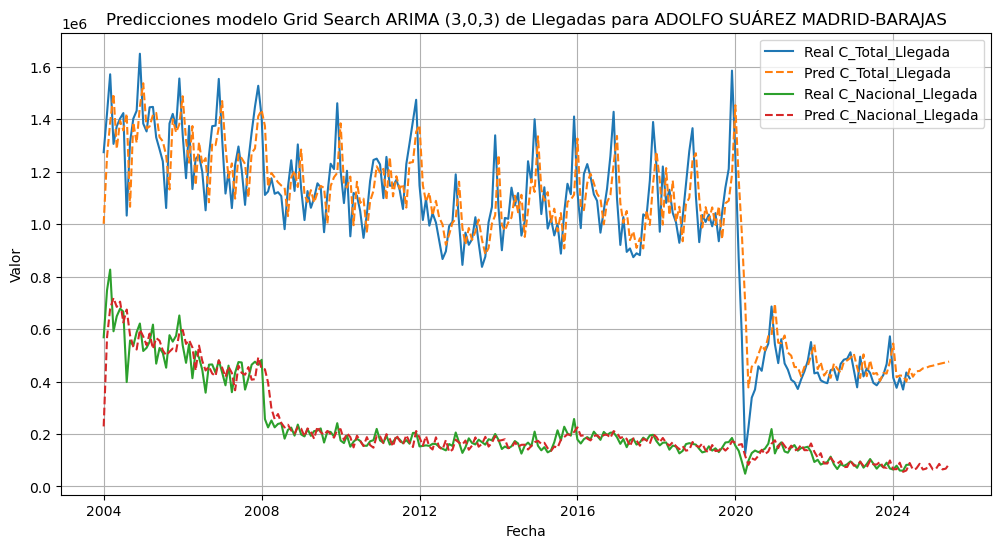

In [31]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correos = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Correos if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Correos_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correo_GS2 = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correos_GS2 = Predicciones_Correos_GS2[(Predicciones_Correos_GS2['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correos_GS2['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correo_GS2.index, Datos_Reales_Correo_GS2['Valor'], label=f'Real {Tipo_Correos_Prediccion}')
    plt.plot(Datos_Predicciones_Correos_GS2['Fecha'], Datos_Predicciones_Correos_GS2['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correos_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (3,0,3) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

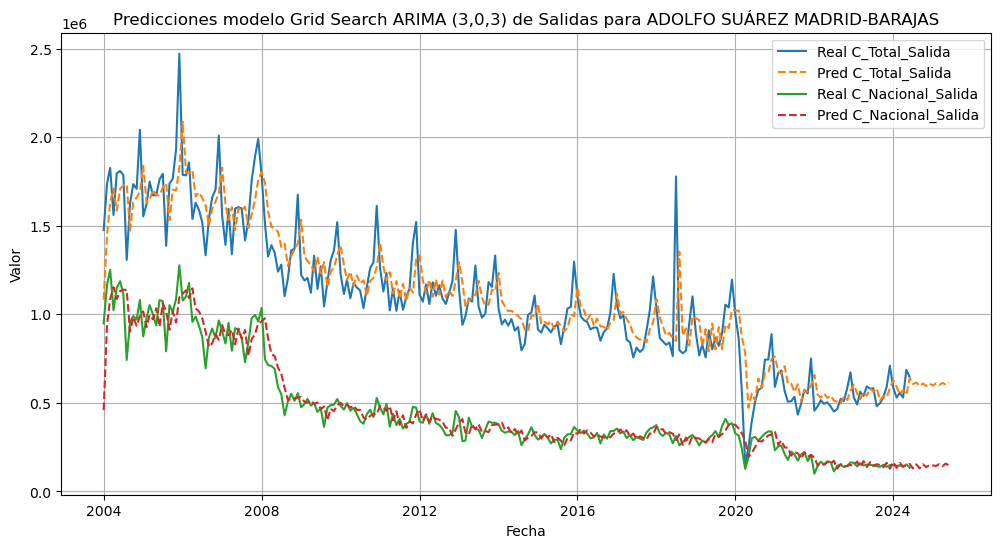

In [32]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correos = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Correos if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Correos_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correo_GS2 = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correos_GS2 = Predicciones_Correos_GS2[(Predicciones_Correos_GS2['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correos_GS2['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correo_GS2.index, Datos_Reales_Correo_GS2['Valor'], label=f'Real {Tipo_Correos_Prediccion}')
    plt.plot(Datos_Predicciones_Correos_GS2['Fecha'], Datos_Predicciones_Correos_GS2['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correos_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (3,0,3) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**3-d. Métricas de error**

In [33]:
# Función para calcular SMAPE
def smape(y_true_GS2, y_pred_GS2):
    return 100 / len(y_true_GS2) * np.sum(2 * np.abs(y_pred_GS2 - y_true_GS2) / (np.abs(y_true_GS2) + np.abs(y_pred_GS2)))

# Se añade la métrica SMAPE
Metricas_Error_Correos_GS2 = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Correo), (Predicciones_Originales_GS2, _, Fechas_Reales) in Dicc_Predicciones_Correo_GS2.items():
    # Se obtienen los valores reales
    Valores_Reales_Correos_GS2 = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Correo_Unico['Tipo'] == Correo)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Correos_GS2) == len(Predicciones_Originales_GS2):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Correos_GS2, Predicciones_Originales_GS2)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Correos_GS2, Predicciones_Originales_GS2))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Correos_GS2 - Predicciones_Originales_GS2) / np.where(Valores_Reales_Correos_GS2 == 0, 1, Valores_Reales_Correos_GS2))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Correos_GS2, Predicciones_Originales_GS2)
        
        Temp_Metricas_Error_GS2 = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Correo],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Correos_GS2 = pd.concat([Metricas_Error_Correos_GS2, Temp_Metricas_Error_GS2], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Correo}")

# Se muestran las métricas
print(Metricas_Error_Correos_GS2)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     C_Total_Llegada      46.972015   
1                        A CORUÑA  C_Nacional_Llegada      45.774425   
2                        A CORUÑA      C_Total_Salida     199.943527   
3                        A CORUÑA   C_Nacional_Salida     208.237926   
4    ADOLFO SUÁREZ MADRID-BARAJAS     C_Total_Llegada  100200.045698   
..                            ...                 ...            ...   
191                     SON BONET   C_Nacional_Salida       0.032386   
192              MURCIA COMBINADO     C_Total_Llegada       1.304098   
193              MURCIA COMBINADO  C_Nacional_Llegada       0.000005   
194              MURCIA COMBINADO      C_Total_Salida       2.296913   
195              MURCIA COMBINADO   C_Nacional_Salida       0.189800   

              RMSE         MAPE       SMAPE  
0       149.500300  2205.923866  187.441503  
1       148.122290  2131.225127  187.274733

**3-e. Métricas de error promedias de todo el conjunto**

In [34]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_GS2 = Metricas_Error_Correos_GS2['MAE'].mean()
RMSE_promedio_GS2 = Metricas_Error_Correos_GS2['RMSE'].mean()
MAPE_promedio_GS2 = Metricas_Error_Correos_GS2['MAPE'].mean()
SMAPE_promedio_GS2 = Metricas_Error_Correos_GS2['SMAPE'].mean()


# Se muestran los resultados GRID SEARCH ARIMA (3,0,3)
print(f"MAE Promedio GRID SEARCH ARIMA (3,0,3): {MAE_promedio_GS2}")
print(f"RMSE Promedio GRID SEARCH ARIMA (3,0,3): {RMSE_promedio_GS2}")
print(f"MAPE Promedio GRID SEARCH ARIMA (3,0,3): {MAPE_promedio_GS2}%")
print(f"SMAPE Promedio GRID SEARCH ARIMA (3,0,3): {SMAPE_promedio_GS2}%")

MAE Promedio GRID SEARCH ARIMA (3,0,3): 2945.128254065849
RMSE Promedio GRID SEARCH ARIMA (3,0,3): 4672.372578228722
MAPE Promedio GRID SEARCH ARIMA (3,0,3): 4286.436244848791%
SMAPE Promedio GRID SEARCH ARIMA (3,0,3): 146.85851993468194%


- MAE Promedio GRID SEARCH ARIMA (3,0,0): 3045.2082773587285
- RMSE Promedio GRID SEARCH ARIMA (3,0,0): 4788.305926414798
- MAPE Promedio GRID SEARCH ARIMA (3,0,0): 3406.276218543832%
- SMAPE Promedio GRID SEARCH ARIMA (3,0,0): 146.13805546265675%
  
Si se observan los valores promedios del modelos GRID SEARCH ARIMA (3,0,0) comparado con los modelos anteriores, tanto el MAE como el RSM  han disminuido, por lo que la precisión y la predicción mejoran con respecto a los anteriores.
Por ahora son los mejores datos promedios obtenidos.

**4. Modelo Random Search - ARIMA**

Se prueba otro modelo de búsqueda de los mejores parámetros esta vez, de manera aleatoria, sin comprobar todas las combinaciones posibles,Random Search, y, además como el ampliar el rango, en el modelo anterior funcionó, en este caso también se vuelve a ampliar hasta 7.

In [35]:
# Se definen los rangos de p, d, q
p = d = q = range(0, 7) 
# Se crean las combinaciones posibles de p, d, q
pdq = list(itertools.product(p, d, q))

# Se define el número de combinaciones
N_Iteraciones = 11  #

# Se selecciona el número de combinaciones e iteracciones aleatoriamente
Combinaciones_Aleatorias_RS = random.sample(pdq, N_Iteraciones)

In [36]:
# Se almcenan los mejores resultados
Mejor_aic = float('inf')
Mejor_params = None

# Se itera sobre cada combinación de parámetros
for params in Combinaciones_Aleatorias_RS:
    try:
        # Se entrena el modelo ARIMA con los parámetros actuales
        model_arima_RS = ARIMA(Datos_Reales_Correos['Valor'], order=params)
        model_fit_arima_RS = model_arima_RS.fit()
        
        # Se calcula el AIC
        aic = model_fit_arima_RS.aic
        
        # Si el AIC actual es mejor que el anterior, actualizar los mejores parámetros
        if aic < Mejor_aic:
            Mejor_aic = aic
            Mejor_params = params
            
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

print(f'Mejor conjunto de parámetros: {Mejor_params} con AIC: {Mejor_aic}')

Mejor conjunto de parámetros: (3, 0, 3) con AIC: 6188.407857706695


**4-a. Se reentrena el modelo con los parámetros obtenidos, Modelo Random Search - ARIMA**

Como los datos que ofrece el modelo ya se han probado, se reentrena el modelo otro conjunto de parámetross (3,1,3)

In [37]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Correos_RS = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Correo_Unico['Aeropuerto_Base'].unique()
Tipos_Correos= Correo_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Correo in Tipos_Correos:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Correos_RS = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Correo_Unico['Tipo'] == Correo)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Correos_RS = Datos_Reales_Correos_RS.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_RS = ARIMA(Datos_Reales_Correos_RS['Valor'], order=(3, 1, 3))
            model_fit_arima_RS = model_arima_RS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_RS = model_fit_arima_RS.predict(start=Datos_Reales_Correos_RS.index[0], end=Datos_Reales_Correos_RS.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_RS = model_fit_arima_RS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Correos_RS[(Aeropuerto, Correo)] = (Predicciones_Originales_RS, Predicciones_Futuras_RS, Datos_Reales_Correos_RS.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Correo}: {e}")

**4-b. Dataframe en el que se guardan las predicciones y los datos reales**

In [38]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_RS_C = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_RS, Predicciones_Futuras_RS, Fechas_Reales) in Dicc_Predicciones_Correos_RS.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Valor Real': Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Correo_Unico['Tipo'] == Correo)]['Valor'],
        'Prediccion': Predicciones_Originales_RS
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_RS), freq='MS')
    Temp_Predicciones_Futuras_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_RS),
        'Prediccion': Predicciones_Futuras_RS
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_RS_C = pd.concat([Comparacion_Total_Todos_Aeropuertos_RS_C, Tem_Predicciones_Historicas_RS, Temp_Predicciones_Futuras_RS], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_RS_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01          0    0.000804
50549  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01          0    0.000779
50550  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01          0    0.000755
50551  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01          0    0.000731
50552  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01          0    0.000708
50553  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01          0    0.000686
50554  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01          0    0.000665
50555  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01          0    0.000644
50556  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01       None    0.000624
50557  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01       None    0.000905
50558  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01       None    0.000927
50559  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01       None    0.000951

In [39]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_RS_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_RS_C['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_RS_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_RS_C['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_RS_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_RS_C['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_RS_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_RS_C['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_RS_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01       0,00       0,00
50549  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01       0,00       0,00
50550  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01       0,00       0,00
50551  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01       0,00       0,00
50552  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01       0,00       0,00
50553  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01       0,00       0,00
50554  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01       0,00       0,00
50555  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01       0,00       0,00
50556  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01                  0,00
50557  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01                  0,00
50558  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01                  0,00
50559  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01                  0,00
50560  MURCI

**4-c. Visualización de las predicciones**

In [40]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Correos_RS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_RS, Predicciones_Futuras_RS, Fechas_Reales) in Dicc_Predicciones_Correos_RS.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_RS
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_RS), freq='MS')
    Temp_Predicciones_Futuras_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_RS
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Correos_RS = pd.concat([Predicciones_Correos_RS, Tem_Predicciones_Historicas_RS, Temp_Predicciones_Futuras_RS], ignore_index=True)

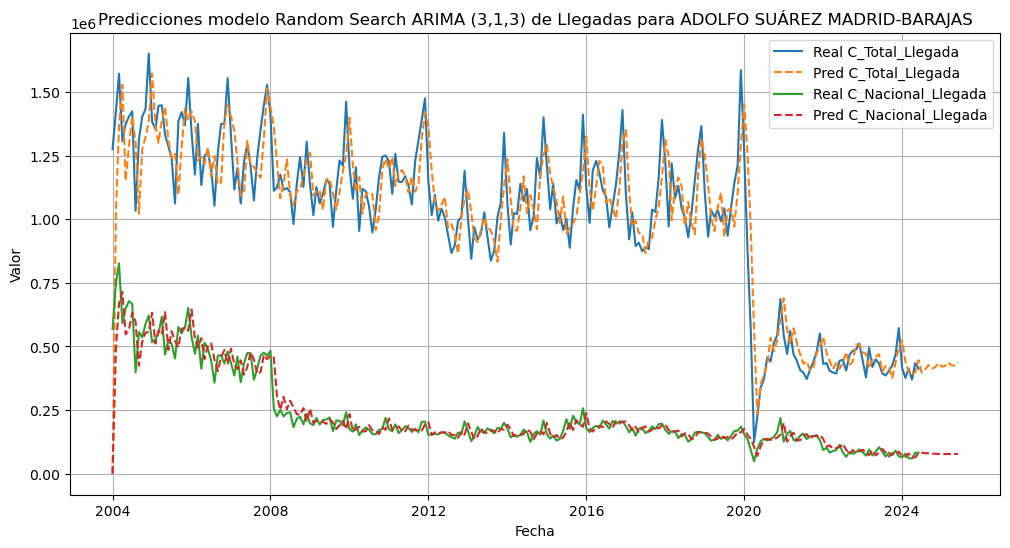

In [41]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correos = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Correos if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Correos_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correo_RS = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correo_RS = Predicciones_Correos_RS[(Predicciones_Correos_RS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correos_RS['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correo_RS.index, Datos_Reales_Correo_RS['Valor'], label=f'Real {Tipo_Correos_Prediccion}')
    plt.plot(Datos_Predicciones_Correo_RS['Fecha'], Datos_Predicciones_Correo_RS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correos_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Random Search ARIMA (3,1,3) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

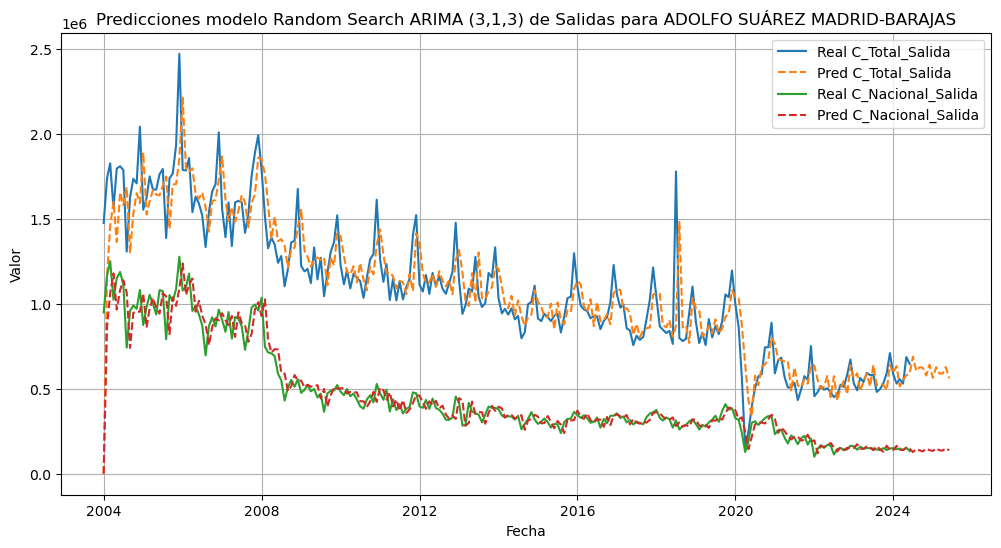

In [42]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correos = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Correos if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Correos_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correo_RS = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correo_RS = Predicciones_Correos_RS[(Predicciones_Correos_RS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correos_RS['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correo_RS.index, Datos_Reales_Correo_RS['Valor'], label=f'Real {Tipo_Correos_Prediccion}')
    plt.plot(Datos_Predicciones_Correo_RS['Fecha'], Datos_Predicciones_Correo_RS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correos_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Random Search ARIMA (3,1,3) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**4-d. Métricas de error**

In [44]:
# Función para calcular SMAPE
def smape(y_true_RS, y_pred_RS):
    return 100 / len(y_true_RS) * np.sum(2 * np.abs(y_pred_RS - y_true_RS) / (np.abs(y_true_RS) + np.abs(y_pred_RS)))

# Se añade la métrica SMAPE
Metricas_Error_Correo_RS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Correo), (Predicciones_Originales_RS, _, Fechas_Reales) in Dicc_Predicciones_Correos_RS.items():
    # Se obtienen los valores reales
    Valores_Reales_Correo_RS = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Correo_Unico['Tipo'] == Correo)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Correo_RS) == len(Predicciones_Originales_RS):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Correo_RS, Predicciones_Originales_RS)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Correo_RS, Predicciones_Originales_RS))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Correo_RS - Predicciones_Originales_RS) / np.where(Valores_Reales_Correo_RS == 0, 1, Valores_Reales_Correo_RS))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Correo_RS, Predicciones_Originales_RS)
        
        Temp_Metricas_Error_RS = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Correo],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Correo_RS = pd.concat([Metricas_Error_Correo_RS, Temp_Metricas_Error_RS], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Correo}")

# Se muestran las métricas
print(Metricas_Error_Correo_RS)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     C_Total_Llegada      46.531204   
1                        A CORUÑA  C_Nacional_Llegada      46.532388   
2                        A CORUÑA      C_Total_Salida     178.970306   
3                        A CORUÑA   C_Nacional_Salida     179.162615   
4    ADOLFO SUÁREZ MADRID-BARAJAS     C_Total_Llegada  100001.481844   
..                            ...                 ...            ...   
191                     SON BONET   C_Nacional_Salida       0.021535   
192              MURCIA COMBINADO     C_Total_Llegada       1.237802   
193              MURCIA COMBINADO  C_Nacional_Llegada       0.000000   
194              MURCIA COMBINADO      C_Total_Salida       2.906830   
195              MURCIA COMBINADO   C_Nacional_Salida       0.271469   

              RMSE         MAPE       SMAPE  
0       148.789842  2018.479610  187.629823  
1       147.286155  2031.500430  187.649914

**4-d. Métricas de error promedias de todo el conjunto**

In [45]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_RS = Metricas_Error_Correo_RS['MAE'].mean()
RMSE_promedio_RS = Metricas_Error_Correo_RS['RMSE'].mean()
MAPE_promedio_RS = Metricas_Error_Correo_RS['MAPE'].mean()
SMAPE_promedio_RS = Metricas_Error_Correo_RS['SMAPE'].mean()

# Se muestran los resultados RANDOM SEARCH ARIMA (3,1,3)
print(f"MAE Promedio RANDOM SEARCH ARIMA (3,1,3): {MAE_promedio_RS}")
print(f"RMSE Promedio RANDOM SEARCH ARIMA (3,1,3): {RMSE_promedio_RS}")
print(f"MAPE Promedio RANDOM SEARCH ARIMA (3,1,3): {MAPE_promedio_RS}%")
print(f"SMAPE Promedio RANDOM SEARCH ARIMA (3,1,3): {SMAPE_promedio_RS}%")

MAE Promedio RANDOM SEARCH ARIMA (3,1,3): 3089.7609085329186
RMSE Promedio RANDOM SEARCH ARIMA (3,1,3): 5271.829537955884
MAPE Promedio RANDOM SEARCH ARIMA (3,1,3): 3327.8650127382944%
SMAPE Promedio RANDOM SEARCH ARIMA (3,1,3): 86.9630541383299%


Este modelo no ha mejorado en medias con respecto al modelo anterior GRID SEARCH ARIMA (3,0,3) como se puede comprobar con los datos obtenidos de las métricas de errores.

- MAE Promedio GRID SEARCH ARIMA (3,0,3): 2945.128254065849
- RMSE Promedio GRID SEARCH ARIMA (3,0,3): 4672.372578228722
- MAPE Promedio GRID SEARCH ARIMA (3,0,3): 4286.436244848791%
- SMAPE Promedio GRID SEARCH ARIMA (3,0,3): 146.85851993468194%

**5. Modelo Exponencial Holt-Winters - aditivo**

Dado que las series presentan cierta estacionalidad se prueba con este tipo de modelo, para ver si mejoran las predicciones

In [46]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_HoltWinters_AD_C = {}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Correo_Unico['Aeropuerto_Base'].unique()
Tipos_Correo = Correo_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Correo in Tipos_Correo:
        # Se filtra cada aeropuerto y tipo de operación
        Datos_Reales_Correo_HW_AD = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                      (Correo_Unico['Tipo'] == Correo)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Correo_HW_AD = Datos_Reales_Correo_HW_AD.sort_index()

        # Se entrena el modelo Holt-Winters en los datos históricos
        try:
            model_hw_AD = ExponentialSmoothing(Datos_Reales_Correo_HW_AD['Valor'], 
                                            trend='add', 
                                            seasonal='add', 
                                            seasonal_periods=12)
            model_fit_hw_AD = model_hw_AD.fit()

            # Se realizan predicciones para los valores históricos
            Predicciones_Originales_HWA = model_fit_hw_AD.predict(start=Datos_Reales_Correo_HW_AD.index[0], end=Datos_Reales_Correo_HW_AD.index[-1])

            # Se realizan predicciones para fechas futuras, el siguiente año completo, 12 meses
            Predicciones_Futuras_HWA = model_fit_hw_AD.forecast(steps=12)

             # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_HoltWinters_AD_C[(Aeropuerto, Correo)] = (Predicciones_Originales_HWA, Predicciones_Futuras_HWA, Datos_Reales_Correo_HW_AD.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo Holt-Winters ADitivo para {Aeropuerto}, {Correo}: {e}")

**5-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [47]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_HWA_C = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_HWA, Predicciones_Futuras_HWA, Fechas_Reales) in Dicc_Predicciones_HoltWinters_AD_C.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Valor Real': Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Correo_Unico['Tipo'] == Correo)]['Valor'],
        'Prediccion': Predicciones_Originales_HWA
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_HWA), freq='MS')
    Temp_Predicciones_Futuras_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_HWA),
        'Prediccion': Predicciones_Futuras_HWA
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_HWA_C = pd.concat([Comparacion_Total_Todos_Aeropuertos_HWA_C, Tem_Predicciones_Historicas_HWA, Temp_Predicciones_Futuras_HWA], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_HWA_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01          0   -0.121511
50549  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01          0   -0.156314
50550  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01          0   -0.227270
50551  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01          0   -0.151142
50552  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01          0   -0.084582
50553  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01          0   -0.073949
50554  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01          0   -0.159893
50555  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01          0    0.622124
50556  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01       None    0.221215
50557  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01       None   -0.228779
50558  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01       None   -0.228803
50559  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01       None   -0.228773

In [48]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_HWA_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_HWA_C['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_HWA_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA_C['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_HWA_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_HWA_C['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_HWA_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA_C['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_HWA_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01       0,00      -0,12
50549  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01       0,00      -0,16
50550  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01       0,00      -0,23
50551  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01       0,00      -0,15
50552  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01       0,00      -0,08
50553  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01       0,00      -0,07
50554  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01       0,00      -0,16
50555  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01       0,00       0,62
50556  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01                  0,22
50557  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01                 -0,23
50558  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01                 -0,23
50559  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01                 -0,23
50560  MURCI

**5-b. Métricas de error**

In [49]:
# Función para calcular SMAPE
def smape(y_true_HWA, y_pred_HWA):
    return 100 / len(y_true_HWA) * np.sum(2 * np.abs(y_pred_HWA - y_true_HWA) / (np.abs(y_true_HWA) + np.abs(y_pred_HWA)))

# Se añade la métrica SMAPE
Metricas_Error_Correo_HWA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Correo), (Predicciones_Originales_HWA, _, Fechas_Reales) in Dicc_Predicciones_HoltWinters_AD_C.items():
    # Se obtienen los valores reales
    Valores_Reales_Correo_HWA = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Correo_Unico['Tipo'] == Correo)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Correo_HWA) == len(Predicciones_Originales_HWA):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Correo_HWA, Predicciones_Originales_HWA)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Correo_HWA, Predicciones_Originales_HWA))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Correo_HWA - Predicciones_Originales_HWA) / np.where(Valores_Reales_Correo_HWA == 0, 1, Valores_Reales_Correo_HWA))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Correo_HWA, Predicciones_Originales_HWA)
        
        Temp_Metricas_Error_HWA = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Correo],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Correo_HWA = pd.concat([Metricas_Error_Correo_HWA, Temp_Metricas_Error_HWA], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Correo}")

# Se muestran las métricas
print(Metricas_Error_Correo_HWA)

                  Aeropuerto_Base                Tipo           MAE  \
0                        A CORUÑA     C_Total_Llegada  5.667906e+01   
1                        A CORUÑA  C_Nacional_Llegada  5.099932e+01   
2                        A CORUÑA      C_Total_Salida  1.705788e+02   
3                        A CORUÑA   C_Nacional_Salida  1.704802e+02   
4    ADOLFO SUÁREZ MADRID-BARAJAS     C_Total_Llegada  6.399637e+04   
..                            ...                 ...           ...   
191                     SON BONET   C_Nacional_Salida  4.069075e-02   
192              MURCIA COMBINADO     C_Total_Llegada  1.706335e+00   
193              MURCIA COMBINADO  C_Nacional_Llegada  3.395883e-08   
194              MURCIA COMBINADO      C_Total_Salida  3.989790e+00   
195              MURCIA COMBINADO   C_Nacional_Salida  3.981698e-01   

             RMSE         MAPE       SMAPE  
0    1.570098e+02  2721.793911  188.994620  
1    1.562304e+02  2172.855814  189.597517  
2    5.48316

**5-c. Métricas de error promedias de todo el conjunto**

In [50]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_HWA = Metricas_Error_Correo_HWA['MAE'].mean()
RMSE_promedio_HWA = Metricas_Error_Correo_HWA['RMSE'].mean()
MAPE_promedio_HWA = Metricas_Error_Correo_HWA['MAPE'].mean()
SMAPE_promedio_HWA = Metricas_Error_Correo_HWA['SMAPE'].mean()

# Se muestran los resultados Holt-Winters Aditivo
print(f"MAE Promedio Holt-Winters Aditivo: {MAE_promedio_HWA}")
print(f"RMSE Promedio Holt-Winters Aditivo: {RMSE_promedio_HWA}")
print(f"MAPE Promedio Holt-Winters Aditivo: {MAPE_promedio_HWA}%")
print(f"SMAPE Promedio Holt-Winters Aditivo: {SMAPE_promedio_HWA}%")

MAE Promedio Holt-Winters Aditivo: 2594.55941296295
RMSE Promedio Holt-Winters Aditivo: 3983.8491878078453
MAPE Promedio Holt-Winters Aditivo: 7618.356632274079%
SMAPE Promedio Holt-Winters Aditivo: 149.5699898148312%


Se comparan los datos promedios con el que mejores resultados ha dado hasta el momento:

- MAE Promedio GRID SEARCH ARIMA (3,0,3): 2945.128254065849
- RMSE Promedio GRID SEARCH ARIMA (3,0,3): 4672.372578228722
- MAPE Promedio GRID SEARCH ARIMA (3,0,3): 4286.436244848791%
- SMAPE Promedio GRID SEARCH ARIMA (3,0,3): 146.85851993468194%

Al igual que ocurrió con los datos de operaciones y pasajeros, este modelo es el que más ha mejorado las métricas.
Por lo que por ahora este es el mejor modelo.
Del mismo modo, no se va a probar con el multiplicativo, debido a que se conoce que hay aeropuertos para los cuales no hay datos va a haber problemas a la hora de realizar el modelo.

**6. Modelo Random Forest con Random Search**

Se prueba otro Random Forest pero esta vez con el Random Search, para obtener los hiperparámetros de manera aleatoria

In [51]:
#Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Correo_RF = {}

# Función para crear variables lag
# Los lags permiten capturar patrones y dependencias en los datos pasados para mejorar la precisión de valores futuros
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se definen los posibles hiperparámetros del modelo para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Correo_Unico['Aeropuerto_Base'].unique()
Tipos_Correos = Correo_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Correo in Tipos_Correos:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Correos_RF = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Correo_Unico['Tipo'] == Correo)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Correos_RF = Datos_Reales_Correos_RF.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_RF = crear_lags(Datos_Reales_Correos_RF['Valor'], lags)
        
        # Se separa el conjunto en entrenamiento (80%) y test (20%)
        X = data_lags_RF.drop(columns=['Valor'])
        y = data_lags_RF['Valor']
        X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Se aplica RandomizedSearchCV para encontrar los mejores hiperparámetros
        try:
            model_RF = RandomForestRegressor(random_state=42)
            random_search = RandomizedSearchCV(model_RF, param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
            random_search.fit(X_train_RF, y_train_RF)

            # Se entrena el modelo con los mejores hiperparámetros encontrados
            best_rf_model = random_search.best_estimator_

            # Se realiza las predicciones sobre los datos históricos
            Predicciones_Originales_RF = best_rf_model.predict(X_test_RF)
            
            # Se realiza las predicciones futuras, pero es necesario construir las características de manera iterativa
            last_values = X_test_RF.iloc[-1].values
            Predicciones_Futuras_RF = []
            for _ in range(12):
                next_pred = best_rf_model.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_RF.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]  # Extraer el valor escalar de next_pred

            # Se convierten las predicciones futuras en un array de pandas
            Predicciones_Futuras_RF = pd.Series(Predicciones_Futuras_RF)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Correo_RF[(Aeropuerto, Correo)] = (Predicciones_Originales_RF, Predicciones_Futuras_RF, Datos_Reales_Correos_RF.index[-len(Predicciones_Originales_RF):])
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Correo}: {e}")

# Se muestra el mejor conjunto de parámetros
print(f"Mejor conjunto de parámetros: {random_search.best_params_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 

**6-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [52]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_RF_C = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_RF, Predicciones_Futuras_RF, Fechas_Reales) in Dicc_Predicciones_Correo_RF.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Correos_RF = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                  (Correo_Unico['Tipo'] == Correo)].loc[Fechas_Reales, 'Valor']
    
    # Alinear las fechas para que ambas series tengan las mismas fechas
    Fechas_Coincidentes = Valores_Reales_Correos_RF.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_RF_Al = Predicciones_Originales_RF[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Correo_RF_Al = Valores_Reales_Correos_RF.loc[Fechas_Coincidentes]
    
    # Se comprueba que ambas longitudes coinciden
    if len(Valores_Reales_Correo_RF_Al) == len(Predicciones_Originales_RF_Al):
        # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
        Tem_Predicciones_Historicas_RF = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto] * len(Fechas_Coincidentes),
            'Tipo': [Correo] * len(Fechas_Coincidentes),
            'Fecha': Fechas_Coincidentes,
            'Valor Real': Valores_Reales_Correo_RF_Al,
            'Prediccion': Predicciones_Originales_RF_Al
        })

        # Se concatenan las predicciones históricas
        Comparacion_Total_Todos_Aeropuertos_RF_C = pd.concat([Comparacion_Total_Todos_Aeropuertos_RF_C, Tem_Predicciones_Historicas_RF], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden después de la alineación para {Aeropuerto} - {Correo}")

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_RF_C.tail(20))

       Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
9584  MURCIA COMBINADO  C_Nacional_Salida 2022-11-01          0    0.067724
9585  MURCIA COMBINADO  C_Nacional_Salida 2022-12-01          0    0.067724
9586  MURCIA COMBINADO  C_Nacional_Salida 2023-01-01          0    0.067724
9587  MURCIA COMBINADO  C_Nacional_Salida 2023-02-01          0    0.067724
9588  MURCIA COMBINADO  C_Nacional_Salida 2023-03-01          0    0.067724
9589  MURCIA COMBINADO  C_Nacional_Salida 2023-04-01          0    0.067724
9590  MURCIA COMBINADO  C_Nacional_Salida 2023-05-01          0    0.067724
9591  MURCIA COMBINADO  C_Nacional_Salida 2023-06-01          0    0.067724
9592  MURCIA COMBINADO  C_Nacional_Salida 2023-07-01          0    0.067724
9593  MURCIA COMBINADO  C_Nacional_Salida 2023-08-01          0    0.067724
9594  MURCIA COMBINADO  C_Nacional_Salida 2023-09-01          0    0.067724
9595  MURCIA COMBINADO  C_Nacional_Salida 2023-10-01          0    0.067724
9596  MURCIA

In [53]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_RF_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_RF_C['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_RF_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_RF_C['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_RF_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_RF_C['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_RF_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_RF_C['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_RF_C.tail(20))

       Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
9584  MURCIA COMBINADO  C_Nacional_Salida 2022-11-01       0,00       0,07
9585  MURCIA COMBINADO  C_Nacional_Salida 2022-12-01       0,00       0,07
9586  MURCIA COMBINADO  C_Nacional_Salida 2023-01-01       0,00       0,07
9587  MURCIA COMBINADO  C_Nacional_Salida 2023-02-01       0,00       0,07
9588  MURCIA COMBINADO  C_Nacional_Salida 2023-03-01       0,00       0,07
9589  MURCIA COMBINADO  C_Nacional_Salida 2023-04-01       0,00       0,07
9590  MURCIA COMBINADO  C_Nacional_Salida 2023-05-01       0,00       0,07
9591  MURCIA COMBINADO  C_Nacional_Salida 2023-06-01       0,00       0,07
9592  MURCIA COMBINADO  C_Nacional_Salida 2023-07-01       0,00       0,07
9593  MURCIA COMBINADO  C_Nacional_Salida 2023-08-01       0,00       0,07
9594  MURCIA COMBINADO  C_Nacional_Salida 2023-09-01       0,00       0,07
9595  MURCIA COMBINADO  C_Nacional_Salida 2023-10-01       0,00       0,07
9596  MURCIA COMBINADO  C

**6-b. Métricas de error**

In [54]:
# Función para calcular SMAPE
def smape(y_true_RF, y_pred_RF):
    return 100 / len(y_true_RF) * np.sum(2 * np.abs(y_pred_RF - y_true_RF) / (np.abs(y_true_RF) + np.abs(y_pred_RF)))

# Se añade la métrica SMAPE
Metricas_Error_Correo_RF = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Correo), (Predicciones_Originales_RF, _, Fechas_Reales) in Dicc_Predicciones_Correo_RF.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Correo_RF = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Correo_Unico['Tipo'] == Correo)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Correo_RF.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_RF_Al = Predicciones_Originales_RF[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Correo_RF_Al = Valores_Reales_Correo_RF.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Correo_RF_Al) == len(Predicciones_Originales_RF_Al):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Correo_RF_Al, Predicciones_Originales_RF_Al)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Correo_RF_Al, Predicciones_Originales_RF_Al))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Correo_RF_Al - Predicciones_Originales_RF_Al) / np.where(Valores_Reales_Correo_RF_Al == 0, 1, Valores_Reales_Correo_RF_Al))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Correo_RF_Al, Predicciones_Originales_RF_Al)
        
        Temp_Metricas_Error_RF = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Correo],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Correo_RF = pd.concat([Metricas_Error_Correo_RF, Temp_Metricas_Error_RF], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Correo}")

# Se muestran las métricas
print(Metricas_Error_Correo_RF)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     C_Total_Llegada      69.511995   
1                        A CORUÑA  C_Nacional_Llegada      68.428185   
2                        A CORUÑA      C_Total_Salida     158.784599   
3                        A CORUÑA   C_Nacional_Salida     157.959746   
4    ADOLFO SUÁREZ MADRID-BARAJAS     C_Total_Llegada  312549.780347   
..                            ...                 ...            ...   
191                     SON BONET   C_Nacional_Salida       0.022073   
192              MURCIA COMBINADO     C_Total_Llegada       0.423968   
193              MURCIA COMBINADO  C_Nacional_Llegada       0.000000   
194              MURCIA COMBINADO      C_Total_Salida       1.318706   
195              MURCIA COMBINADO   C_Nacional_Salida       0.067724   

              RMSE         MAPE       SMAPE  
0       206.999204  2592.103264  185.892850  
1       206.378892  2502.948412  185.642253

**6-c. Métricas de error promedias de todo el conjunto**

In [55]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_RF = Metricas_Error_Correo_RF['MAE'].mean()
RMSE_promedio_RF = Metricas_Error_Correo_RF['RMSE'].mean()
MAPE_promedio_RF = Metricas_Error_Correo_RF['MAPE'].mean()
SMAPE_promedio_RF = Metricas_Error_Correo_RF['SMAPE'].mean()

# Se muestran los resultados Random Forest - random search
print(f"MAE Promedio Random Forest - random search: {MAE_promedio_RF}")
print(f"RMSE Promedio Random Forest - random search: {RMSE_promedio_RF}")
print(f"MAPE Promedio Random Forest - random search: {MAPE_promedio_RF}%")
print(f"SMAPE Promedio Random Forest - random search: {SMAPE_promedio_RF}%")

MAE Promedio Random Forest - random search: 4532.385817242907
RMSE Promedio Random Forest - random search: 5101.23681300513
MAPE Promedio Random Forest - random search: 26900.910841060955%
SMAPE Promedio Random Forest - random search: 115.12042346535182%


En términos generales, este modelo ha empeorado con respecto al anterior tanto para las métricas de MAE como RMSE, por lo que también se descarta.

**7. Modelo Autoarima**

El último modelo que se va a probar es el AutoARIMA

In [56]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_AutoARIMA_C = {}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Correo_Unico['Aeropuerto_Base'].unique()
Tipos_Correos = Correo_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Correo in Tipos_Correos:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Correos_ARIMA = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                         (Correo_Unico['Tipo'] == Correo)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Correos_ARIMA = Datos_Reales_Correos_ARIMA.sort_index()

        # Se entrena el modelo AutoARIMA
        try:
            model_auto_arima = auto_arima(Datos_Reales_Correos_ARIMA['Valor'], 
                                          seasonal=False, 
                                          stepwise=True, 
                                          trace=True, 
                                          error_action='ignore', 
                                          suppress_warnings=True)
            
            # Se realizan predicciones sobre los datos históricos
            Predicciones_Originales_ARIMA = model_auto_arima.predict_in_sample()
            
            # Se realizan predicciones para fechas futuras, 12 meses por ejemplo
            Predicciones_Futuras_ARIMA = model_auto_arima.predict(n_periods=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_AutoARIMA_C[(Aeropuerto, Correo)] = (Predicciones_Originales_ARIMA, Predicciones_Futuras_ARIMA, Datos_Reales_Correos_ARIMA.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo AutoARIMA para {Aeropuerto}, {Correo}: {e}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3193.968, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3299.766, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3250.756, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3190.056, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3297.766, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3191.309, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3191.192, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3193.047, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3188.067, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3189.333, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3189.216, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3248.756, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3191.069, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.091 seconds
Performing stepwise se

**7-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [57]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_ARIMA, Predicciones_Futuras_ARIMA, Fechas_Reales) in Dicc_Predicciones_AutoARIMA_C.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Correo_AutoARIMA = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Correo_Unico['Tipo'] == Correo)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_ARIMA), len(Valores_Reales_Correo_AutoARIMA))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Correo] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Correo_AutoARIMA[:min_len],
        'Prediccion': Predicciones_Originales_ARIMA[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_AutoARIMA = Tem_Predicciones_Historicas_AutoARIMA.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_ARIMA), freq='MS')
    Temp_Predicciones_Futuras_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_ARIMA),
        'Tipo': [Correo] * len(Predicciones_Futuras_ARIMA),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_ARIMA),
        'Prediccion': Predicciones_Futuras_ARIMA
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_AutoARIMA = Temp_Predicciones_Futuras_AutoARIMA.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C = pd.concat([Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C, Tem_Predicciones_Historicas_AutoARIMA, Temp_Predicciones_Futuras_AutoARIMA], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  \
50548  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01         0.0   
50549  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01         0.0   
50550  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01         0.0   
50551  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01         0.0   
50552  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01         0.0   
50553  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01         0.0   
50554  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01         0.0   
50555  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01         0.0   
50556  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01         NaN   
50557  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01         NaN   
50558  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01         NaN   
50559  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01         NaN   
50560  MURCIA COMBINADO  C_Nacional_Salida 2024-11-01         NaN   
50561  MURCIA COMBINADO  C_Naciona

In [58]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_AutoARIMA_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01       0,00      -0,00
50549  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01       0,00       0,00
50550  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01       0,00      -0,00
50551  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01       0,00       0,00
50552  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01       0,00      -0,00
50553  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01       0,00       0,00
50554  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01       0,00      -0,00
50555  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01       0,00       0,00
50556  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01                 -0,00
50557  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01                  0,00
50558  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01                  0,00
50559  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01                  0,00
50560  MURCI

**7-b.Visualización de las predicciones**

In [59]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Correo_AutoARIMA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_ARIMA, Predicciones_Futuras_ARIMA, Fechas_Reales) in Dicc_Predicciones_AutoARIMA_C.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_ARIMA
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_ARIMA), freq='MS')
    Temp_Predicciones_Futuras_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_ARIMA
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Correo_AutoARIMA = pd.concat([Predicciones_Correo_AutoARIMA, Tem_Predicciones_Historicas_AutoARIMA, Temp_Predicciones_Futuras_AutoARIMA], ignore_index=True)

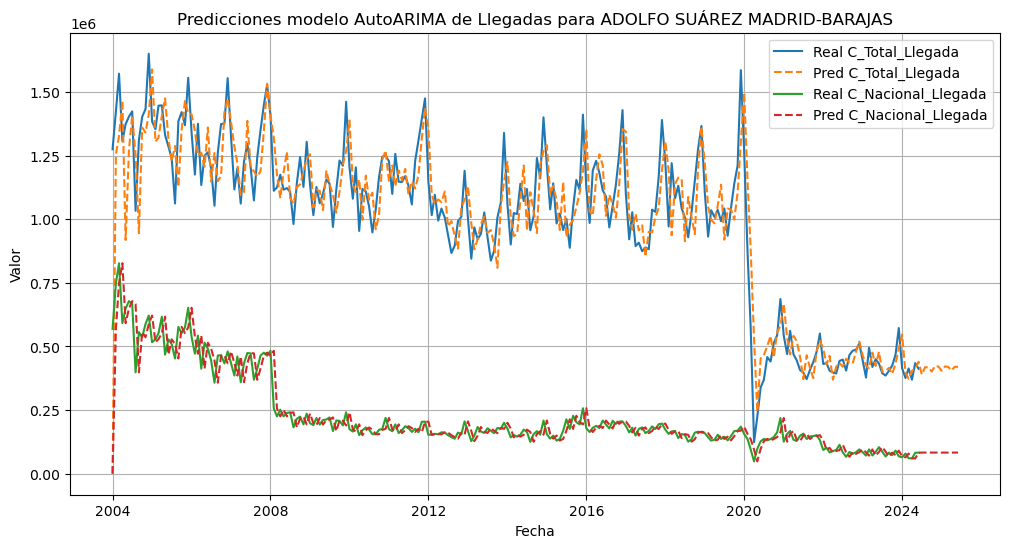

In [60]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correos = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Correos if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Correos_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correo_ARIMA = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correo_ARIMA = Predicciones_Correo_AutoARIMA[(Predicciones_Correo_AutoARIMA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correo_AutoARIMA['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correo_ARIMA.index, Datos_Reales_Correo_ARIMA['Valor'], label=f'Real {Tipo_Correos_Prediccion}')
    plt.plot(Datos_Predicciones_Correo_ARIMA['Fecha'], Datos_Predicciones_Correo_ARIMA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correos_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo AutoARIMA de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

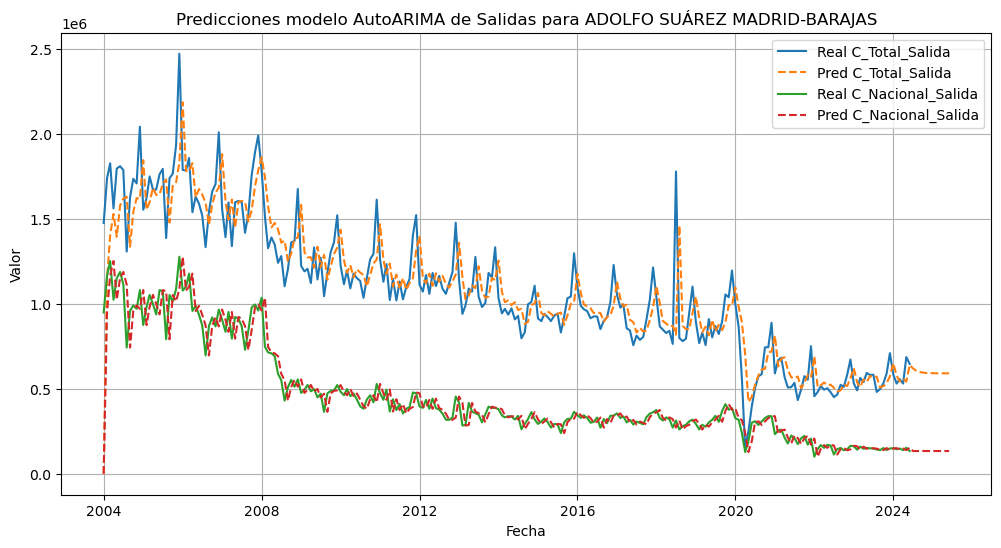

In [61]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correos = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Correos if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Correos_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correo_ARIMA = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correo_ARIMA = Predicciones_Correo_AutoARIMA[(Predicciones_Correo_AutoARIMA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correo_AutoARIMA['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correo_ARIMA.index, Datos_Reales_Correo_ARIMA['Valor'], label=f'Real {Tipo_Correos_Prediccion}')
    plt.plot(Datos_Predicciones_Correo_ARIMA['Fecha'], Datos_Predicciones_Correo_ARIMA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correos_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo AutoARIMA de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**7-c. Métricas de error**

In [62]:
# Función para calcular SMAPE
def smape(y_true_Auto, y_pred_Auto):
    return 100 / len(y_true_Auto) * np.sum(2 * np.abs(y_pred_Auto - y_true_Auto) / (np.abs(y_true_Auto) + np.abs(y_pred_Auto)))

# Se añade la métrica SMAPE
Metricas_Error_Correo_Auto = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Correo), (Predicciones_Originales_ARIMA, _, Fechas_Reales) in Dicc_Predicciones_AutoARIMA_C.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Correo_AutoARIMA = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Correo_Unico['Tipo'] == Correo)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Correo_AutoARIMA.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_ARIMA = Predicciones_Originales_ARIMA[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Correo_AutoARIMA = Valores_Reales_Correo_AutoARIMA.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Correo_AutoARIMA) == len(Predicciones_Originales_ARIMA):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Correo_AutoARIMA, Predicciones_Originales_ARIMA)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Correo_AutoARIMA, Predicciones_Originales_ARIMA))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Correo_AutoARIMA - Predicciones_Originales_ARIMA) / np.where(Valores_Reales_Correo_AutoARIMA == 0, 1, Valores_Reales_Correo_AutoARIMA))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Correo_AutoARIMA, Predicciones_Originales_ARIMA)
        
        Temp_Metricas_Error_AutoARIMA = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Correo],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Correo_Auto = pd.concat([Metricas_Error_Correo_Auto, Temp_Metricas_Error_AutoARIMA], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Correo}")

# Se muestran las métricas
print(Metricas_Error_Correo_Auto)

                  Aeropuerto_Base                Tipo           MAE  \
0                        A CORUÑA     C_Total_Llegada     40.004059   
1                        A CORUÑA  C_Nacional_Llegada     39.511647   
2                        A CORUÑA      C_Total_Salida    181.118872   
3                        A CORUÑA   C_Nacional_Salida    202.319765   
4    ADOLFO SUÁREZ MADRID-BARAJAS     C_Total_Llegada  97360.623463   
..                            ...                 ...           ...   
191                     SON BONET   C_Nacional_Salida      0.016260   
192              MURCIA COMBINADO     C_Total_Llegada      1.345577   
193              MURCIA COMBINADO  C_Nacional_Llegada      0.000000   
194              MURCIA COMBINADO      C_Total_Salida      1.572219   
195              MURCIA COMBINADO   C_Nacional_Salida      0.108993   

              RMSE         MAPE       SMAPE  
0       160.015460   975.886398  187.783234  
1       157.985445   980.515069  187.836674  
2       5

**7-d. Métricas de error promedias de todo el conjunto**

In [63]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_AutoARIMA = Metricas_Error_Correo_Auto['MAE'].mean()
RMSE_promedio_AutoARIMA = Metricas_Error_Correo_Auto['RMSE'].mean()
MAPE_promedio_AutoARIMA = Metricas_Error_Correo_Auto['MAPE'].mean()
SMAPE_promedio_AutoARIMA = Metricas_Error_Correo_Auto['SMAPE'].mean()

# Se muestran los resultados AutoARIMA
print(f"MAE Promedio AutoARIMA: {MAE_promedio_AutoARIMA}")
print(f"RMSE Promedio AutoARIMA: {RMSE_promedio_AutoARIMA}")
print(f"MAPE Promedio AutoARIMA): {MAPE_promedio_AutoARIMA}%")
print(f"SMAPE Promedio AutoARIMA): {SMAPE_promedio_AutoARIMA}%")

MAE Promedio AutoARIMA: 3092.867694885284
RMSE Promedio AutoARIMA: 5279.446045574714
MAPE Promedio AutoARIMA): 3687.265371644275%
SMAPE Promedio AutoARIMA): 74.74089145002895%


Nuevamente, este modelo mejoró con respecto al RandomForest, pero si se compara con el que mejor resultado se había obtenido hasta el momento, modelo Holt-Winters Aditivo:

- MAE Promedio Holt-Winters Aditivo: 2594.55941296295
- RMSE Promedio Holt-Winters Aditivo: 3983.8491878078453
- MAPE Promedio Holt-Winters Aditivo: 7618.356632274079%
- SMAPE Promedio Holt-Winters Aditivo: 149.5699898148312%
  
Se ve que no, las métricas promedios distan considerablemente de ellas

**8. Modelo K-Vecinos**

In [5]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Correos_K = {}

# Función para crear variables lag
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Correo_Unico['Aeropuerto_Base'].unique()
Tipos_Correos = Correo_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Correo in Tipos_Correos:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Correo_K = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Correo_Unico['Tipo'] == Correo)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Correo_K = Datos_Reales_Correo_K.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_K = crear_lags(Datos_Reales_Correo_K['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (75%) y test (25%)
        X = data_lags_K.drop(columns=['Valor'])
        y = data_lags_K['Valor']
        X_train_K, X_test_K, y_train_K, y_test_K = train_test_split(X, y, test_size=0.25, shuffle=False)
        
        # Entrenamiento y predicciones
        try:
            
            model_K = KNeighborsRegressor(n_neighbors=7)
            model_K.fit(X_train_K, y_train_K)

            # Predicciones sobre los datos históricos
            Predicciones_Originales_K = model_K.predict(X_test_K)

            # Predicciones futuras
            last_values = X_test_K.iloc[-1].values
            Predicciones_Futuras_K = []
            for _ in range(12):
                next_pred = model_K.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_K.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]

            Predicciones_Futuras_K = pd.Series(Predicciones_Futuras_K)

            # Almacenar las predicciones en el diccionario
            Dicc_Predicciones_Correos_K[(Aeropuerto, Correo)] = (Predicciones_Originales_K, Predicciones_Futuras_K, Datos_Reales_Correo_K.index[-len(Predicciones_Originales_K):])

        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Correo}: {e}")

**8-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [6]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_K_C = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_K, Predicciones_Futuras_K, Fechas_Reales) in Dicc_Predicciones_Correos_K.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Correo_K = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Correo_Unico['Tipo'] == Correo)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_K), len(Valores_Reales_Correo_K))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_K = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Correo] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Correo_K[:min_len],
        'Prediccion': Predicciones_Originales_K[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_K= Tem_Predicciones_Historicas_K.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_K), freq='MS')
    Temp_Predicciones_Futuras_K= pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_K),
        'Tipo': [Correo] * len(Predicciones_Futuras_K),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_K),
        'Prediccion': Predicciones_Futuras_K
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_K = Temp_Predicciones_Futuras_K.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_K_C = pd.concat([Comparacion_Total_Todos_Aeropuertos_K_C, Tem_Predicciones_Historicas_K, Temp_Predicciones_Futuras_K], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_K_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
14288  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01         0.0         0.0
14289  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01         0.0         0.0
14290  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01         0.0         0.0
14291  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01         0.0         0.0
14292  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01         0.0         0.0
14293  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01         0.0         0.0
14294  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01         0.0         0.0
14295  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01         0.0         0.0
14296  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01         NaN         0.0
14297  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01         NaN         0.0
14298  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01         NaN         0.0
14299  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01         Na

In [7]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_K_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_K_C['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_K_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_K_C['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_K_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_K_C['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_K_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_K_C['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_K_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
14288  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01       0,00       0,00
14289  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01       0,00       0,00
14290  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01       0,00       0,00
14291  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01       0,00       0,00
14292  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01       0,00       0,00
14293  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01       0,00       0,00
14294  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01       0,00       0,00
14295  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01       0,00       0,00
14296  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01                  0,00
14297  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01                  0,00
14298  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01                  0,00
14299  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01                  0,00
14300  MURCI

**8-b.Visualización de las predicciones**

In [8]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Correo_K = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_K, Predicciones_Futuras_K, Fechas_Reales) in Dicc_Predicciones_Correos_K.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_K = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_K
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_K), freq='MS')
    Temp_Predicciones_Futuras_K = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_K
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Correo_K = pd.concat([Predicciones_Correo_K, Tem_Predicciones_Historicas_K, Temp_Predicciones_Futuras_K], ignore_index=True)

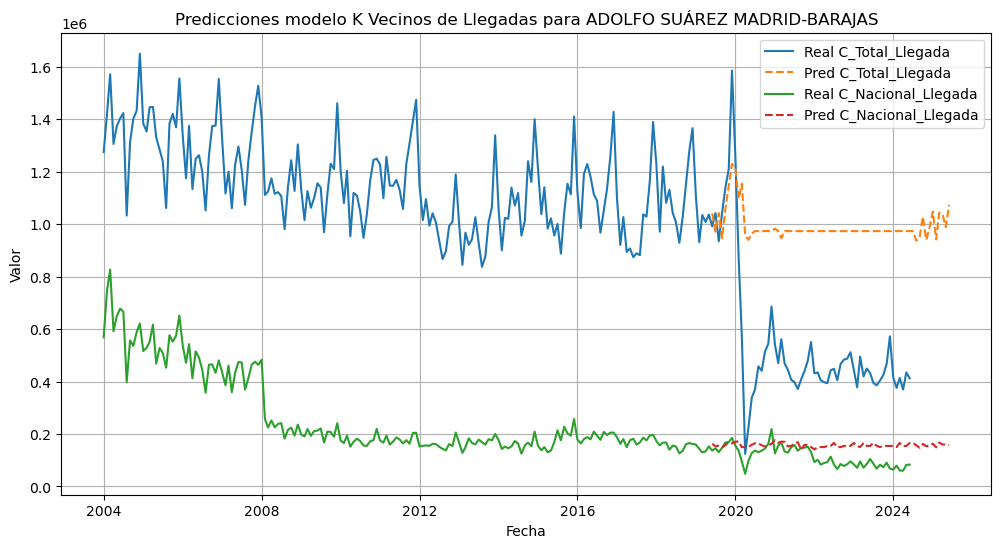

In [9]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correo = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Correo if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Correo_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correo_K = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correo_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correo_K = Predicciones_Correo_K[(Predicciones_Correo_K['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correo_K['Tipo'] == Tipo_Correo_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correo_K.index, Datos_Reales_Correo_K['Valor'], label=f'Real {Tipo_Correo_Prediccion}')
    plt.plot(Datos_Predicciones_Correo_K['Fecha'], Datos_Predicciones_Correo_K['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correo_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo K Vecinos de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

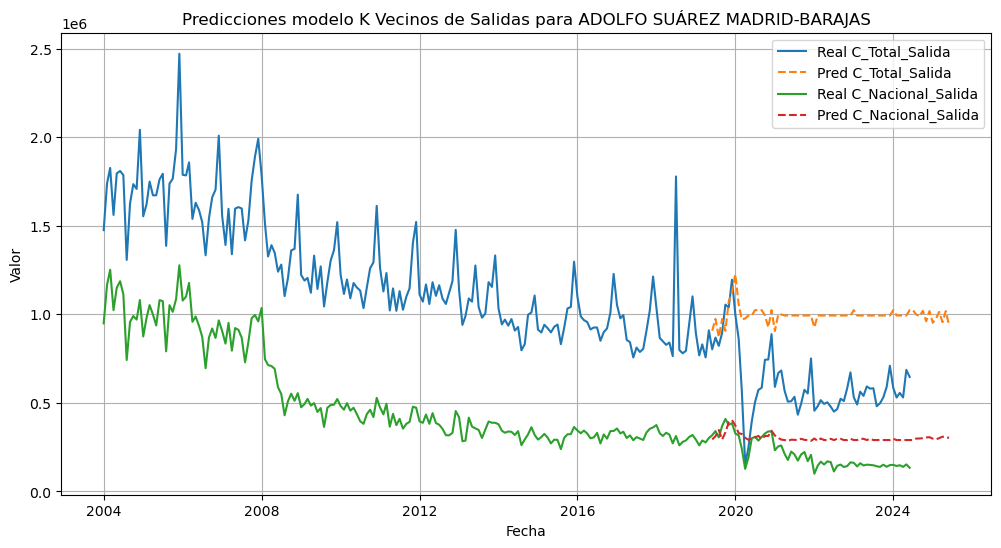

In [10]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correo = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Correo if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Correo_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correo_K = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correo_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correo_K = Predicciones_Correo_K[(Predicciones_Correo_K['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correo_K['Tipo'] == Tipo_Correo_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correo_K.index, Datos_Reales_Correo_K['Valor'], label=f'Real {Tipo_Correo_Prediccion}')
    plt.plot(Datos_Predicciones_Correo_K['Fecha'], Datos_Predicciones_Correo_K['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correo_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo K Vecinos de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**8-c. Métricas de error**

In [12]:
# Función para calcular SMAPE
def smape(y_true_K, y_pred_K):
    return 100 / len(y_true_K) * np.sum(2 * np.abs(y_pred_K - y_true_K) / (np.abs(y_true_K) + np.abs(y_pred_K)))

# Se añade la métrica SMAPE
Metricas_Error_Correos_K = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Correo), (Predicciones_Originales_K, _, Fechas_Reales) in Dicc_Predicciones_Correos_K.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Correo_K = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Correo_Unico['Tipo'] == Correo)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Correo_K.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_K = Predicciones_Originales_K[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Correo_K = Valores_Reales_Correo_K.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Correo_K) == len(Predicciones_Originales_K):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Correo_K, Predicciones_Originales_K)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Correo_K, Predicciones_Originales_K))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Correo_K - Predicciones_Originales_K) / np.where(Valores_Reales_Correo_K == 0, 1, Valores_Reales_Correo_K))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Correo_K, Predicciones_Originales_K)
        
        Temp_Metricas_Error_K = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Correo],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Correos_K = pd.concat([Metricas_Error_Correos_K, Temp_Metricas_Error_K], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Correo}")

# Se muestran las métricas
print(Metricas_Error_Correos_K)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     C_Total_Llegada      75.524590   
1                        A CORUÑA  C_Nacional_Llegada      74.208431   
2                        A CORUÑA      C_Total_Salida     584.974239   
3                        A CORUÑA   C_Nacional_Salida     585.159251   
4    ADOLFO SUÁREZ MADRID-BARAJAS     C_Total_Llegada  475877.252927   
..                            ...                 ...            ...   
191                     SON BONET   C_Nacional_Salida       0.000000   
192              MURCIA COMBINADO     C_Total_Llegada       0.428571   
193              MURCIA COMBINADO  C_Nacional_Llegada       0.000000   
194              MURCIA COMBINADO      C_Total_Salida       0.000000   
195              MURCIA COMBINADO   C_Nacional_Salida       0.000000   

              RMSE          MAPE       SMAPE  
0       258.084694    467.145822  119.331511  
1       256.705442    447.206990  117.478

**8d. Métricas de error promedias de todo el conjunto**

In [13]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_K = Metricas_Error_Correos_K['MAE'].mean()
RMSE_promedio_K = Metricas_Error_Correos_K['RMSE'].mean()
MAPE_promedio_K = Metricas_Error_Correos_K['MAPE'].mean()
SMAPE_promedio_K = Metricas_Error_Correos_K['SMAPE'].mean()

# Se muestran los resultados K-Vecinos
print(f"MAE Promedio K-Vecinos: {MAE_promedio_K}")
print(f"RMSE Promedio K-Vecinos: {RMSE_promedio_K}")
print(f"MAPE Promedio K-Vecinos: {MAPE_promedio_K}%")
print(f"SMAPE Promedio K-Vecinos: {SMAPE_promedio_K}%")

MAE Promedio K-Vecinos: 6879.7350284376025
RMSE Promedio K-Vecinos: 7766.983628997952
MAPE Promedio K-Vecinos: 28306.300240887416%
SMAPE Promedio K-Vecinos: 82.84123276810723%


Como se puede comprobar en los gráficos, los datos de las predicciones difieren mucho de los datos reales, y también se puede ver que los valores promedios han empeorado.

**9. MPL Regressor**

In [15]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Correos_MPL = {}

# Función para crear variables lag
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Correo_Unico['Aeropuerto_Base'].unique()
Tipos_Correos = Correo_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Correo in Tipos_Correos:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Correo_MPL = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Correo_Unico['Tipo'] == Correo)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Correo_MPL = Datos_Reales_Correo_MPL.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_MPL = crear_lags(Datos_Reales_Correo_MPL['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (75%) y test (25%)
        X = data_lags_MPL.drop(columns=['Valor'])
        y = data_lags_MPL['Valor']
        X_train_MPL, X_test_MPL, y_train_MPL, y_test_MPL = train_test_split(X, y, test_size=0.25, shuffle=False)
        
        # Entrenamiento y predicciones
        try:
            
            model_MPL = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter=500)
            model_MPL.fit(X_train_MPL, y_train_MPL)

            # Predicciones sobre los datos históricos
            Predicciones_Originales_MPL = model_MPL.predict(X_test_MPL)

            # Predicciones futuras
            last_values = X_test_MPL.iloc[-1].values
            Predicciones_Futuras_MPL= []
            for _ in range(12):
                next_pred = model_MPL.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_MPL.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]

            Predicciones_Futuras_MPL = pd.Series(Predicciones_Futuras_MPL)

            # Almacenar las predicciones en el diccionario
            Dicc_Predicciones_Correos_MPL[(Aeropuerto, Correo)] = (Predicciones_Originales_MPL, Predicciones_Futuras_MPL, Datos_Reales_Correo_MPL.index[-len(Predicciones_Originales_MPL):])

        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Correo}: {e}")

**9-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [16]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_MPL_C = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_MPL, Predicciones_Futuras_MPL, Fechas_Reales) in Dicc_Predicciones_Correos_MPL.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Correo_MPL = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Correo_Unico['Tipo'] == Correo)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_MPL), len(Valores_Reales_Correo_MPL))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_MPL = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Correo] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Correo_MPL[:min_len],
        'Prediccion': Predicciones_Originales_MPL[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_MPL= Tem_Predicciones_Historicas_MPL.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_MPL), freq='MS')
    Temp_Predicciones_Futuras_MPL= pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_MPL),
        'Tipo': [Correo] * len(Predicciones_Futuras_MPL),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_MPL),
        'Prediccion': Predicciones_Futuras_MPL
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_MPL = Temp_Predicciones_Futuras_MPL.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_MPL_C = pd.concat([Comparacion_Total_Todos_Aeropuertos_MPL_C, Tem_Predicciones_Historicas_MPL, Temp_Predicciones_Futuras_MPL], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_MPL_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
14288  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01         0.0   -0.012635
14289  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01         0.0   -0.012635
14290  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01         0.0   -0.012635
14291  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01         0.0   -0.012635
14292  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01         0.0   -0.012635
14293  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01         0.0   -0.012635
14294  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01         0.0   -0.012635
14295  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01         0.0   -0.012635
14296  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01         NaN   -0.012635
14297  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01         NaN   -0.051733
14298  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01         NaN   -0.227316
14299  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01         Na

In [17]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_MPL_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_MPL_C['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_MPL_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_MPL_C['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_MPL_C['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_MPL_C['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_MPL_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_MPL_C['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_MPL_C.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
14288  MURCIA COMBINADO  C_Nacional_Salida 2023-11-01       0,00      -0,01
14289  MURCIA COMBINADO  C_Nacional_Salida 2023-12-01       0,00      -0,01
14290  MURCIA COMBINADO  C_Nacional_Salida 2024-01-01       0,00      -0,01
14291  MURCIA COMBINADO  C_Nacional_Salida 2024-02-01       0,00      -0,01
14292  MURCIA COMBINADO  C_Nacional_Salida 2024-03-01       0,00      -0,01
14293  MURCIA COMBINADO  C_Nacional_Salida 2024-04-01       0,00      -0,01
14294  MURCIA COMBINADO  C_Nacional_Salida 2024-05-01       0,00      -0,01
14295  MURCIA COMBINADO  C_Nacional_Salida 2024-06-01       0,00      -0,01
14296  MURCIA COMBINADO  C_Nacional_Salida 2024-07-01                 -0,01
14297  MURCIA COMBINADO  C_Nacional_Salida 2024-08-01                 -0,05
14298  MURCIA COMBINADO  C_Nacional_Salida 2024-09-01                 -0,23
14299  MURCIA COMBINADO  C_Nacional_Salida 2024-10-01                 -0,86
14300  MURCI

**9-b.Visualización de las predicciones**

In [18]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Correo_MPL = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_MPL, Predicciones_Futuras_MPL, Fechas_Reales) in Dicc_Predicciones_Correos_MPL.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_MPL = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_MPL
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_MPL), freq='MS')
    Temp_Predicciones_Futuras_MPL = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_MPL
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Correo_MPL = pd.concat([Predicciones_Correo_MPL, Tem_Predicciones_Historicas_MPL, Temp_Predicciones_Futuras_MPL], ignore_index=True)

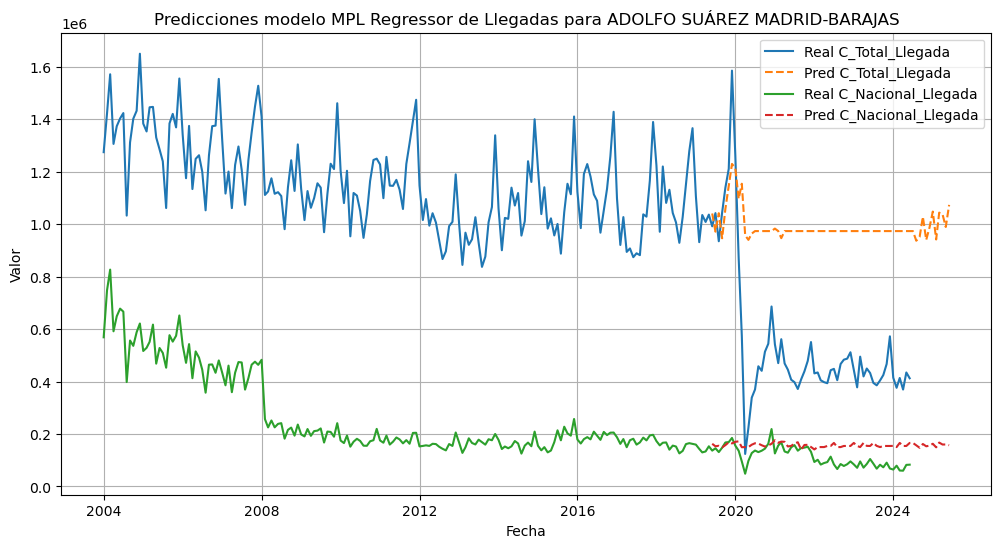

In [19]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correo = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Correo if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Correo_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correo_MPL = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correo_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correo_MPL = Predicciones_Correo_K[(Predicciones_Correo_K['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correo_K['Tipo'] == Tipo_Correo_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correo_MPL.index, Datos_Reales_Correo_MPL['Valor'], label=f'Real {Tipo_Correo_Prediccion}')
    plt.plot(Datos_Predicciones_Correo_MPL['Fecha'], Datos_Predicciones_Correo_MPL['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correo_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo MPL Regressor de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

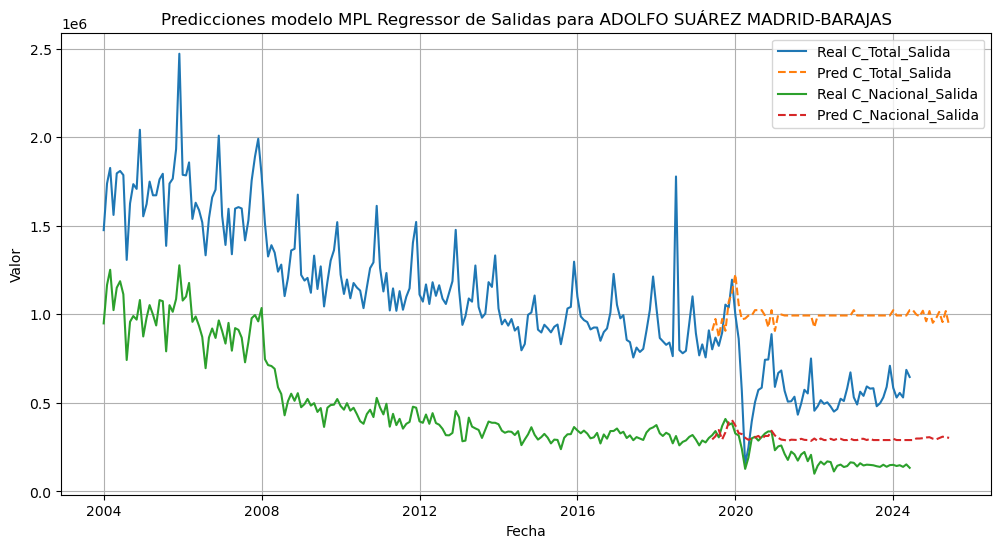

In [20]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correo = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Correo if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Correo_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correo_MPL = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correo_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correo_MPL = Predicciones_Correo_K[(Predicciones_Correo_K['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correo_K['Tipo'] == Tipo_Correo_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correo_MPL.index, Datos_Reales_Correo_MPL['Valor'], label=f'Real {Tipo_Correo_Prediccion}')
    plt.plot(Datos_Predicciones_Correo_MPL['Fecha'], Datos_Predicciones_Correo_MPL['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correo_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo MPL Regressor de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**9-c. Métricas de error**

In [22]:
# Función para calcular SMAPE
def smape(y_true_MPL, y_pred_MPL):
    return 100 / len(y_true_MPL) * np.sum(2 * np.abs(y_pred_MPL - y_true_MPL) / (np.abs(y_true_MPL) + np.abs(y_pred_MPL)))

# Se añade la métrica SMAPE
Metricas_Error_Correos_MPL = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Correo), (Predicciones_Originales_MPL, _, Fechas_Reales) in Dicc_Predicciones_Correos_MPL.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Correo_MPL = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Correo_Unico['Tipo'] == Correo)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Correo_MPL.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_MPL = Predicciones_Originales_MPL[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Correo_MPL = Valores_Reales_Correo_MPL.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Correo_MPL) == len(Predicciones_Originales_MPL):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Correo_MPL, Predicciones_Originales_MPL)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Correo_MPL, Predicciones_Originales_MPL))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Correo_MPL - Predicciones_Originales_MPL) / np.where(Valores_Reales_Correo_MPL == 0, 1, Valores_Reales_Correo_MPL))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Correo_MPL, Predicciones_Originales_MPL)
        
        Temp_Metricas_Error_MPL = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Correo],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Correos_MPL = pd.concat([Metricas_Error_Correos_MPL, Temp_Metricas_Error_MPL], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Correo}")

# Se muestran las métricas
print(Metricas_Error_Correos_MPL)

                  Aeropuerto_Base                Tipo           MAE  \
0                        A CORUÑA     C_Total_Llegada     87.283514   
1                        A CORUÑA  C_Nacional_Llegada     85.347823   
2                        A CORUÑA      C_Total_Salida    587.356237   
3                        A CORUÑA   C_Nacional_Salida    587.201824   
4    ADOLFO SUÁREZ MADRID-BARAJAS     C_Total_Llegada  98457.988154   
..                            ...                 ...           ...   
191                     SON BONET   C_Nacional_Salida      0.004631   
192              MURCIA COMBINADO     C_Total_Llegada      0.466520   
193              MURCIA COMBINADO  C_Nacional_Llegada      0.025132   
194              MURCIA COMBINADO      C_Total_Salida      1.380128   
195              MURCIA COMBINADO   C_Nacional_Salida      0.012635   

              RMSE          MAPE       SMAPE  
0       257.179716   2149.487321  169.714477  
1       257.236700   2038.327975  169.388282  
2     

**9d. Métricas de error promedias de todo el conjunto**

In [23]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_MPL = Metricas_Error_Correos_MPL['MAE'].mean()
RMSE_promedio_MPL = Metricas_Error_Correos_MPL['RMSE'].mean()
MAPE_promedio_MPL= Metricas_Error_Correos_MPL['MAPE'].mean()
SMAPE_promedio_MPL = Metricas_Error_Correos_MPL['SMAPE'].mean()

# Se muestran los resultados MPL
print(f"MAE Promedio MPL: {MAE_promedio_MPL}")
print(f"RMSE Promedio MPL: {RMSE_promedio_MPL}")
print(f"MAPE Promedio MPL: {MAPE_promedio_MPL}%")
print(f"SMAPE Promedio MPL: {SMAPE_promedio_MPL}%")

MAE Promedio MPL: 2322.2345310321616
RMSE Promedio MPL: 3602.6671893432685
MAPE Promedio MPL: 3626.0247541851077%
SMAPE Promedio MPL: 168.23773961134492%


A pesar de que los datos promedios paracen mejorar, si se visualizan las gráficas las predicciones futuras para este modelo son muy diferentes a los datos anteriores, por lo que se va a seguir considerando que el modelo Holt-Winters Aditivo, da mejores predicciones.
Se toma esta decisión debido a que en este fichero hay muchos aeropuertos con datos a 0, y el aeropuerto que más correo mueve es el de Adolfo Suarez Madrid Barajas, es por ello que en este caso se toma la desición basada en las gráficas obtenidas.

Por lo que después de haber probado 9 modelos y no conseguir que mejora, se determina que el mejor modelo también para los datos de correos es
 **modelo de Holt-Winters Aditivo**

### C. Visualizar mejor modelo

In [64]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Correo_HWA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Correo), (Predicciones_Originales_HWA, Predicciones_Futuras_HWA, Fechas_Reales) in Dicc_Predicciones_HoltWinters_AD_C.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_HWA
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_HWA), freq='MS')
    Temp_Predicciones_Futuras_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Correo,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_HWA
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Correo_HWA = pd.concat([Predicciones_Correo_HWA, Tem_Predicciones_Historicas_HWA, Temp_Predicciones_Futuras_HWA], ignore_index=True)

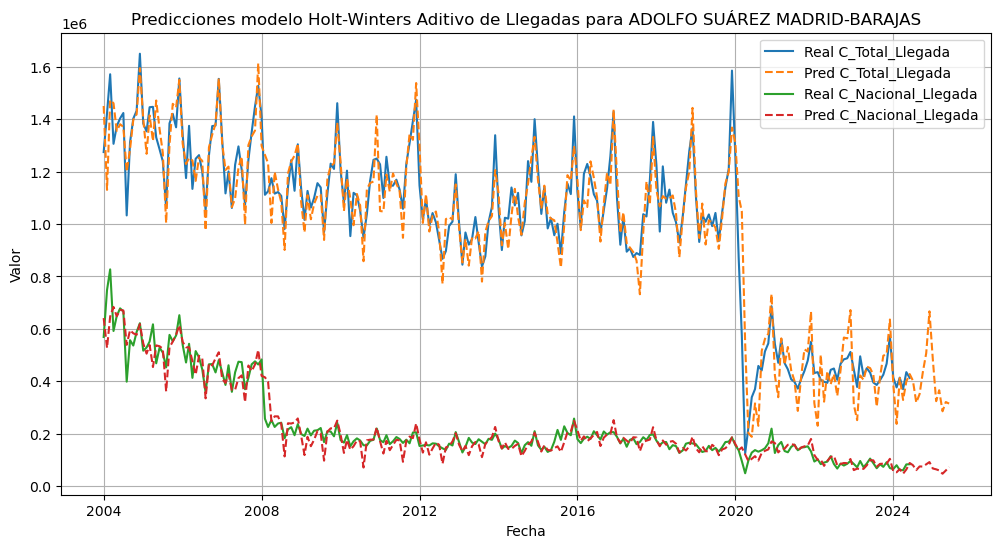

In [65]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correo = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Correo if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Correos_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correo_HWA = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correo_HWA = Predicciones_Correo_HWA[(Predicciones_Correo_HWA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correo_HWA['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correo_HWA.index, Datos_Reales_Correo_HWA['Valor'], label=f'Real {Tipo_Correos_Prediccion}')
    plt.plot(Datos_Predicciones_Correo_HWA['Fecha'], Datos_Predicciones_Correo_HWA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correos_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Holt-Winters Aditivo de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

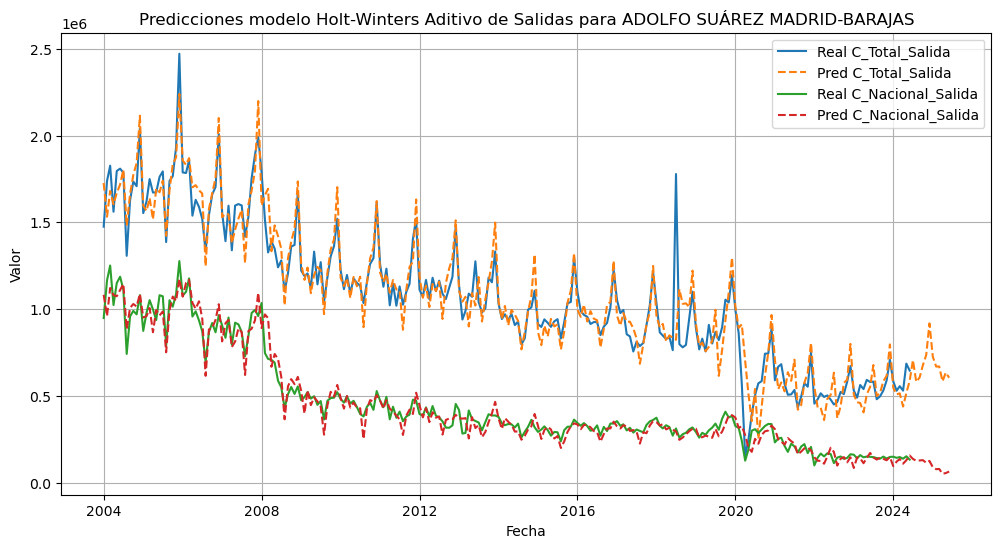

In [66]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Correo = Correo_Unico[Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Correo if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Correos_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Correo_HWA = Correo_Unico[(Correo_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Correo_Unico['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Correo_HWA = Predicciones_Correo_HWA[(Predicciones_Correo_HWA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Correo_HWA['Tipo'] == Tipo_Correos_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Correo_HWA.index, Datos_Reales_Correo_HWA['Valor'], label=f'Real {Tipo_Correos_Prediccion}')
    plt.plot(Datos_Predicciones_Correo_HWA['Fecha'], Datos_Predicciones_Correo_HWA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Correos_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Holt-Winters Aditivo de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

### D. Guardar mejor modelo

In [67]:
# Se guardan los parámetros del modelo para cada aeropuerto
for (Aeropuerto, Correo), model_fit_hw_AD in Dicc_Predicciones_HoltWinters_AD_C.items():
    # Se limpian los nombres de archivos para que sean válidos
    nombre_aeropuerto = re.sub(r'[^\w\s]', '_', Aeropuerto)  # Reemplaza caracteres no alfanuméricos con guion bajo
    nombre_Correo = re.sub(r'[^\w\s]', '_', Correo)
    
    # Se guarda el modelo usando joblib
    try:
        joblib.dump(model_fit_hw_AD, f'modelo_holt_winters_{nombre_aeropuerto}_{nombre_Correo}.pkl')
    except Exception as e:
        print(f"Error al guardar el modelo para {Aeropuerto}, {Correo}: {e}")

### E. Guardar predicciones

In [68]:
# Se especifica la ruta en la que se van a guardar el dataframe
Ruta_Correo_Prediccion = './Ficheros_Predicciones'

# Se crea la carpeta en la que se van a guardar, si esta no existe
if not os.path.exists(Ruta_Correo_Prediccion):
    # Si la carpeta no existe, se crea
    os.makedirs(Ruta_Correo_Prediccion)
    print(f"Carpeta creada: {Ruta_Correo_Prediccion}")
else:
    # Si la carpeta ya existe, se muestra un mensaje
    print(f"La carpeta ya existe: {Ruta_Correo_Prediccion}")

La carpeta ya existe: ./Ficheros_Predicciones


In [69]:
# Ruta para guardar las predicciones
Ruta_Correo_Prediccion = './Ficheros_Predicciones/Predicciones_Correos.csv'

# Se reemplazan las comas por puntos en la columna 'Prediccion'
Comparacion_Total_Todos_Aeropuertos_HWA_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA_C['Prediccion'].str.replace(',', '.')

# Se convierte la columna 'Prediccion' a float
Comparacion_Total_Todos_Aeropuertos_HWA_C['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA_C['Prediccion'].astype(float)

# Se guarda el DataFrame en un archivo CSV con el formato correcto para los flotantes
Comparacion_Total_Todos_Aeropuertos_HWA_C.to_csv(Ruta_Correo_Prediccion, index=False, encoding='utf-8', decimal=',')

print(f"Predicciones de operaciones guardadas en: {Ruta_Correo_Prediccion}")

Predicciones de operaciones guardadas en: ./Ficheros_Predicciones/Predicciones_Correos.csv
